In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import hypergeom
import obonet as obo
import re
from tqdm import tqdm

In [2]:
datadir = '/cellar/users/snwright/Data/RareCommon/'
output_dir='/cellar/users/snwright/Data/RareCommon/outputs'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/RVC_Results/'
input_dir= '/cellar/users/snwright/Data/RareCommon/inputs'

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.5
import matplotlib.font_manager as fm
arial_font_path = '/cellar/users/snwright/Fonts/msfonts/Arial.TTF'
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

In [4]:
import re
def map_trait_code(code):
    efo = next((match.group() for match in re.finditer(r'EFO_\d+', code)), None)
    if efo is not None:
        return efo
    mondo = next((match.group() for match in re.finditer(r'MONDO_\d+', code)), None)
    if mondo is not None:
        return mondo
    hp = next((match.group() for match in re.finditer(r'HP_\d+', code)), None)
    if hp is not None:
        return hp
    go = next((match.group() for match in re.finditer(r'GO_\d+', code)), None)
    if go is not None:
        return go
    oba = next((match.group() for match in re.finditer(r'OBA_\d+', code)), None)
    if oba is not None:
        return oba
    return None

# March 2025

## Load data
### GWASCat/RAVAR

In [6]:
def load_files_from_list(outdir, job_id):
    with open(os.path.join(outdir, f'{job_id}.files'), 'r') as f:
        filenames = [s.strip() for s in f.readlines()] 
    loaded_data = []
    not_found = 0
    for f in filenames:
        try:
            loaded_data.append(pd.read_csv(os.path.join(outdir, f), sep='\t', header=None))
        except:
            not_found += 1
    print(f'Files loaded {len(loaded_data)}', f'Files not found {not_found}')
    results = pd.concat(loaded_data)
    results.columns = ['TraitR', 'TraitC', 'Network','Transform', 'Norm', 'Mean_NPS', 
                             'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ]
    results['logp_nps'] = results.P_mean_NPS.apply(lambda x: -1 * np.log10(x+1e-250))
    results['logp_size'] = results.P_size.apply(lambda x: -1 * np.log10(x+1e-250))
    results['log2SizeOE'] = np.log2(results['Size'] / results['Null_Size'])
    return results


In [36]:
#df = pd.read_csv(os.path.join(output_dir, 'netcoloc/March_2025', 'rvc_qnetcoloc_rv_gc.txt'), sep='\t', header=None,
#                names =['TraitR', 'TraitC', 'Network','Transform', 'Norm','Mean_NPS', 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ])

df = load_files_from_list(os.path.join(output_dir, 'netcoloc', 'March_2025'), 2214576)
df['slurm_idx'] = [x for x in range(len(df))]
df['EFO'] = df.TraitR.apply(lambda x: map_trait_code(x))
df['StudyC'] = df.TraitC.apply(lambda x: next((match.group() for match in re.finditer(r'GCST\d+', x)), None))
df['StudyR'] = df.TraitR.apply(lambda x: x.split('_')[0])
df['trait_pair'] = df['TraitR'] + '_' + df['TraitC']

Files loaded 373 Files not found 0


In [77]:
c_traitlist = pd.read_csv(os.path.join(input_dir, 'March_2025', 'common_Mar28.traitlist'), header=None)[0].values
r_traitlist = pd.read_csv(os.path.join(input_dir, 'March_2025', 'rare_Mar28.traitlist'), header=None)[0].values

In [78]:
trait_pairs = ['_'.join(x) for x in zip(r_traitlist, c_traitlist)]

In [79]:
df[df.logp_size.isna()]

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,logp_nps,logp_size,log2SizeOE,slurm_idx,EFO,StudyC,StudyR,trait_pair


In [80]:
df = df[df.trait_pair.isin(trait_pairs)]
df = df.dropna()

In [81]:
from statsmodels.stats.multitest import fdrcorrection

In [82]:
df['q'] = fdrcorrection(df.P_size.values)[1]
df['logq'] = df.q.apply(lambda z: -1 * np.log10(z + 1e-250))

In [12]:
# need to figure out why one of the traits is giving a nan pvalue

In [83]:
df['plot_color'] = df.logp_size.apply(lambda z: min(z, 25))

In [84]:
df.shape

(373, 22)

## Initial visualization

Text(0.5, 0, 'Phenotypes (n=373)')

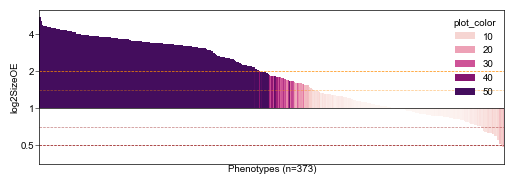

In [85]:
_ = plt.figure(figsize=(6, 2))

df['plot_color'] = df.logq.apply(lambda z: min(z, 50))
sns.barplot(df.sort_values(by='log2SizeOE', ascending=False), x='trait_pair', y='log2SizeOE', hue='plot_color', 
            palette='RdPu', width=1)
_ = plt.xticks([])
plt.hlines(y=0.5, xmin=-0.5, xmax=369, linestyle='--', color='darkorange', alpha=0.5, linewidth=0.5)
plt.hlines(y=-0.5, xmin=-0.5, xmax=369,  linestyle='--', color='darkred', alpha=0.5, linewidth=0.5)
plt.hlines(y=1, xmin=-0.5, xmax=369, linestyle='--', color='darkorange', linewidth=0.5)
plt.hlines(y=-1, xmin=-0.5, xmax=369, linestyle='--', color='darkred', linewidth=0.5)
plt.hlines(y=0, xmin=-0.5, xmax=369.5, color='black', linewidth=0.5)
plt.xlim(-0.5, 368.5)
plt.yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
plt.xlabel(f'Phenotypes (n={len(df)})')
#plt.savefig(os.path.join(figdir, 'coloc_test.svg'), bbox_inches='tight')

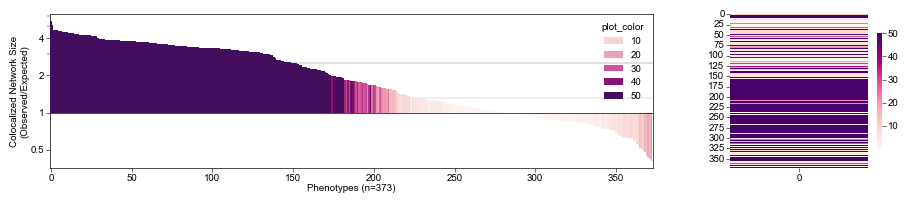

In [86]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(11, 2), gridspec_kw={'width_ratios':[7,2]})

df['plot_color'] = df.logq.apply(lambda z: min(z, 50))
sns.barplot(df.sort_values(by='log2SizeOE', ascending=False), x='trait_pair', y='log2SizeOE', hue='plot_color', 
            palette='RdPu', width=1, zorder=5, ax=ax1)
_ = ax1.set_xticks([])
ax1.hlines(y=[ np.log2(2.5),], xmin=-0.5, xmax=373, linestyle='-', color='black', alpha=0.6, 
           linewidth=0.3, zorder=0)
ax1.hlines(y=[ np.log2(1.3),], xmin=-0.5, xmax=373, linestyle='-', color='black', alpha=0.3, 
           linewidth=0.3, zorder=0)
ax1.hlines(y=0, xmin=-0.5, xmax=373.5, color='black', linewidth=0.5, zorder=6)
ax1.set_xlim(-0.75, 372.75)

ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
ax1.set_ylabel('Colocalized Network Size\n(Observed/Expected)')
ax1.set_xlabel(f'Phenotypes (n={len(df)})')
ax1.set_xticks([0, 50, 100, 150, 200, 250, 300, 350], labels = [0, 50, 100, 150, 200, 250, 300, 350])
sns.heatmap(df.plot_color.values.reshape(373, 1), cmap='RdPu', cbar_kws={'shrink':0.75})
plt.savefig(os.path.join(figdir, 'coloc_test.svg'), bbox_inches='tight')

## Cat vs Cont

In [87]:
gcat_meta = pd.read_csv(os.path.join(datadir, 'inputs', 'gcat_input_features_Mar28.tsv'), sep='\t')
gcat_meta = gcat_meta.rename(columns={'ClassificationFinal':'trait_type', 'DISEASE/TRAIT':'Trait',
                                     'StudyC':'TraitC', 'StudyR':'TraitR'})

In [88]:
###
over_df = pd.read_csv('/cellar/users/snwright/Data/RareCommon/outputs/overlap/March_2025/RV_GC_overlap.txt', sep='\t',
                     header=None, names=['trait_pair', 'param_set', 'n_common', 'n_rare', 'n_overlap', 'background', 'pval'])

over_df['EFO'] = over_df.trait_pair.apply(lambda x: map_trait_code(x))
over_df['StudyC'] = over_df.trait_pair.apply(lambda x: next((match.group() for match in re.finditer(r'GCST\d+', x)), None))
over_df['StudyR'] = over_df.trait_pair.apply(lambda x: x.split('_')[0])
over_df['Expected'] = over_df.n_rare * over_df.n_common / 19000
over_df['logp'] = -1 * np.log10(over_df['pval'] + 1e-250)
over_df.shape

(373, 12)

In [89]:
type_df = df.merge(gcat_meta, on=['TraitC', 'TraitR'], how='inner')
type_df['size_diff'] = type_df['N_C'] = type_df['N_R']
type_df['trait_pair'] = type_df['TraitR'] + '_' + type_df['TraitC']

In [90]:
type_df = type_df.merge(over_df, on='trait_pair', how='inner')

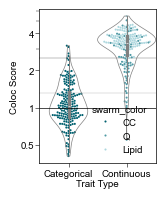

In [91]:
_ = plt.figure(figsize=(1.5,2))

type_df['swarm_color'] = type_df.apply(lambda x: 'Lipid' if x.Domain=='Lipid Measurment' else x.trait_type, axis=1)
sns.violinplot(type_df, x='trait_type', y='log2SizeOE', cut=0, fill=0,color='grey', zorder=2, linewidth=0.5, width=1)
sns.swarmplot(type_df, x='trait_type', y='log2SizeOE', hue='swarm_color', zorder=1, 
              palette=['#00606f', '#509aa5', '#ADD7DE'],  s=1.5)

ax1 = plt.gca()

ax1.hlines(y=[ np.log2(2.5),], xmin=-0.5, xmax=1.5, linestyle='-', color='black', alpha=0.6, 
           linewidth=0.3, zorder=0)
ax1.hlines(y=[ np.log2(1.3),], xmin=-0.5, xmax=1.5, linestyle='-', color='black', alpha=0.3, 
           linewidth=0.3, zorder=0)
ax1.hlines(y=0, xmin=-0.5, xmax=1.5, color='black', linewidth=0.5, zorder=6)
ax1.set_xlim(-0.5, 1.5)
ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
ax1.set_xlabel('Trait Type')
_ = ax1.set_xticks([0,1], labels=['Categorical', 'Continuous'])
_ = ax1.set_ylabel('Coloc Score')
plt.savefig(os.path.join(figdir, 'cc_vs_q.svg'), bbox_inches='tight')

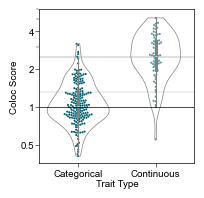

In [23]:
_ = plt.figure(figsize=(2,2))
sns.violinplot(type_df[type_df.Domain!='Lipid Measurment'], x='trait_type', y='log2SizeOE', cut=0, fill=0,color='grey', zorder=2, linewidth=0.5)
sns.swarmplot(type_df[type_df.Domain!='Lipid Measurment'], x='trait_type', y='log2SizeOE', hue='trait_type', zorder=1, palette=['#00606f', '#509aa5'], s=1.5)

ax1 = plt.gca()

ax1.hlines(y=[ np.log2(2.5),], xmin=-0.5, xmax=1.5, linestyle='-', color='black', alpha=0.6, 
           linewidth=0.3, zorder=0)
ax1.hlines(y=[ np.log2(1.3),], xmin=-0.5, xmax=1.5, linestyle='-', color='black', alpha=0.3, 
           linewidth=0.3, zorder=0)
ax1.hlines(y=0, xmin=-0.5, xmax=1.5, color='black', linewidth=0.5, zorder=6)
ax1.set_xlim(-0.5, 1.5)
ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
ax1.set_xlabel('Trait Type')
_ = ax1.set_xticks([0,1], labels=['Categorical', 'Continuous'])
_ = ax1.set_ylabel('Coloc Score')
plt.savefig(os.path.join(figdir, 'cc_vs_q.svg'), bbox_inches='tight')

In [24]:
from scipy.stats import mannwhitneyu
mannwhitneyu(type_df[type_df.trait_type=='CC'].log2SizeOE.values,type_df[(type_df.Domain!='Lipid Measurment') & (type_df.trait_type=='Q')].log2SizeOE.values )

MannwhitneyuResult(statistic=1034.0, pvalue=2.8330945938095983e-25)

In [25]:
print('Total sig coloc', len(type_df[(type_df.log2SizeOE > 0) & (type_df.q < 0.05)]))
print('Total sig coloc %', 100*len(type_df[(type_df.log2SizeOE > 0) & (type_df.q < 0.05)])/373)

Total sig coloc 255
Total sig coloc % 68.36461126005362


In [26]:
print('Total strong', len(type_df[(type_df.log2SizeOE > np.log2(2.5))]))
print('Total strong %', 100*len(type_df[(type_df.log2SizeOE > np.log2(2.5))])/373)

Total strong 154
Total strong % 41.28686327077748


In [27]:
print('Total moderate', len(type_df[(type_df.log2SizeOE > np.log2(1.3)) & (type_df.log2SizeOE < np.log2(2.5))]))
print('Total moderate %', 100*len(type_df[(type_df.log2SizeOE > np.log2(1.3)) & (type_df.log2SizeOE < np.log2(2.5))])/373)

Total moderate 74
Total moderate % 19.839142091152816


In [42]:
from scipy.stats import spearmanr
spearmanr(type_df[type_df.trait_type=='Q'].Jaccard, type_df[type_df.trait_type=='Q'].log2SizeOE)

SignificanceResult(statistic=0.7364215125463113, pvalue=4.697390220558193e-33)

In [41]:
spearmanr(type_df[type_df.trait_type=='CC'].Jaccard, type_df[type_df.trait_type=='CC'].log2SizeOE)

SignificanceResult(statistic=0.35128507237702405, pvalue=8.241580692982339e-07)

In [32]:
type_df['Jaccard'] = type_df.n_overlap / (type_df.n_common + type_df.n_rare - type_df.n_overlap)

In [37]:
type_df[type_df.Jaccard==0]

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,...,n_overlap,background,pval,EFO_y,StudyC_y,StudyR_y,Expected,logp,swarm_color,Jaccard
0,34375979_EFO_0003827,GCST90278093_EFO_0003827,pcnet2_0,neglog10,sum,0.060919,0.000806,2.390000e-17,221,219.653,...,0,19000,0.004046,EFO_0003827,GCST90278093,34375979,0.004053,2.392949,CC,0.0
1,34375979_EFO_0001065,GCST90018839_EFO_0001065,pcnet2_0,neglog10,sum,0.070425,0.001805,5.898000e-27,250,167.391,...,0,19000,0.005777,EFO_0001065,GCST90018839,34375979,0.005789,2.238321,CC,0.0
2,34375979_MONDO_0002253,GCST012616_MONDO_0002253,pcnet2_0,neglog10,sum,-0.005681,0.000735,3.578000e-01,151,180.924,...,0,19000,0.014123,MONDO_0002253,GCST012616,34375979,0.014211,1.850063,CC,0.0
3,28089252_EFO_0004833,GCST90002355_EFO_0004833,pcnet2_0,neglog10,sum,0.273955,-0.001616,5.178000e-166,531,256.723,...,0,19000,0.071409,EFO_0004833,GCST90002355,28089252,0.073684,1.146249,Q,0.0
4,34375979_EFO_0003948,GCST90000514_EFO_0003948,pcnet2_0,neglog10,sum,0.153933,-0.003950,4.790000e-85,296,236.847,...,0,19000,0.015679,EFO_0003948,GCST90000514,34375979,0.015789,1.804671,CC,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,34375979_EFO_0008414,GCST005016_EFO_0008414,pcnet2_0,neglog10,sum,0.052742,0.000500,1.016000e-12,283,232.682,...,0,19000,0.012458,EFO_0008414,GCST005016,34375979,0.012526,1.904553,CC,0.0
367,34375979_EFO_0008404,GCST005003_EFO_0008404,pcnet2_0,neglog10,sum,0.059244,-0.000779,4.298000e-16,178,206.337,...,0,19000,0.015057,EFO_0008404,GCST005003,34375979,0.015158,1.822251,CC,0.0
368,34375979_EFO_0000096,GCST002643_EFO_0000096,pcnet2_0,neglog10,sum,-0.169519,-0.000307,1.733000e-124,116,185.224,...,0,19000,0.001683,EFO_0000096,GCST002643,34375979,0.001684,2.773844,CC,0.0
370,34375979_EFO_0008418,GCST005020_EFO_0008418,pcnet2_0,neglog10,sum,0.015691,-0.004274,7.431000e-03,161,201.280,...,0,19000,0.014226,EFO_0008418,GCST005020,34375979,0.014316,1.846926,CC,0.0


<Axes: xlabel='Jaccard', ylabel='log2SizeOE'>

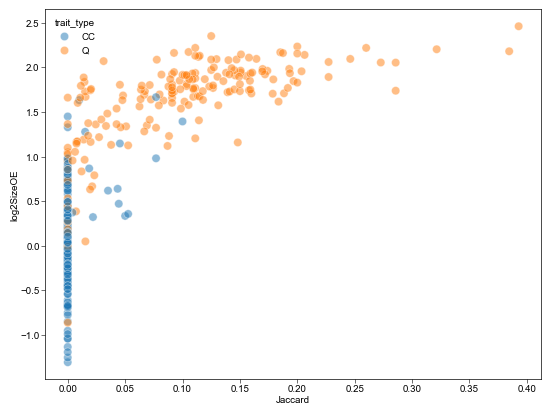

In [43]:
sns.scatterplot(type_df, x='Jaccard', y='log2SizeOE', hue='trait_type', alpha=0.5)

<Axes: xlabel='n_overlap', ylabel='log2SizeOE'>

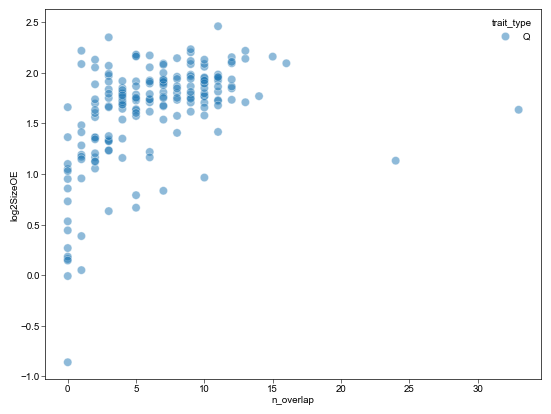

In [154]:
sns.scatterplot(type_df[type_df.trait_type=='Q'], x='n_overlap', y='log2SizeOE', hue='trait_type', alpha=0.5)

(-0.5, 368.5)

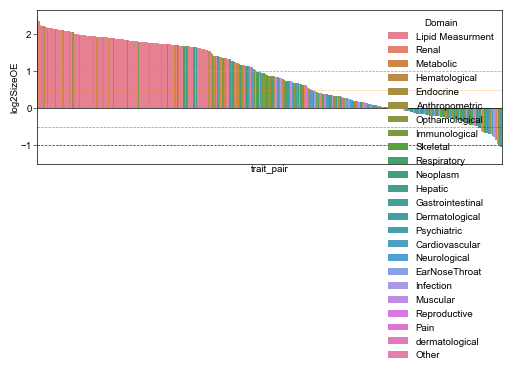

In [155]:
_ = plt.figure(figsize=(6, 2))


sns.barplot(type_df.sort_values(by='log2SizeOE', ascending=False), x='trait_pair', y='log2SizeOE', hue='Domain', width=1)
_ = plt.xticks([])
plt.hlines(y=0.5, xmin=-0.5, xmax=369, linestyle='--', color='darkorange', alpha=0.5, linewidth=0.5)
plt.hlines(y=-0.5, xmin=-0.5, xmax=369,  linestyle='--', color='darkred', alpha=0.5, linewidth=0.5)
plt.hlines(y=1, xmin=-0.5, xmax=369, linestyle='--', color='darkorange', linewidth=0.5)
plt.hlines(y=-1, xmin=-0.5, xmax=369, linestyle='--', color='darkred', linewidth=0.5)
plt.hlines(y=0, xmin=-0.5, xmax=369.5, color='black', linewidth=0.5)
plt.xlim(-0.5, 368.5)

(-0.5, 256.5)

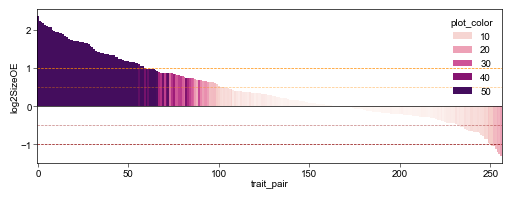

In [158]:
_ = plt.figure(figsize=(6, 2))


sns.barplot(type_df[type_df.Domain != 'Lipid Measurment'].sort_values(by='log2SizeOE', ascending=False), x='trait_pair', 
            y='log2SizeOE',  hue='plot_color', 
            palette='RdPu', width=1)
_ = plt.xticks([])
n = len(type_df[type_df.Domain != 'Lipid Measurment'])
plt.hlines(y=0.5, xmin=-0.5, xmax=n, linestyle='--', color='darkorange', alpha=0.5, linewidth=0.5)
plt.hlines(y=-0.5, xmin=-0.5, xmax=n,  linestyle='--', color='darkred', alpha=0.5, linewidth=0.5)
plt.hlines(y=1, xmin=-0.5, xmax=n, linestyle='--', color='darkorange', linewidth=0.5)
plt.hlines(y=-1, xmin=-0.5, xmax=n, linestyle='--', color='darkred', linewidth=0.5)
plt.hlines(y=0, xmin=-0.5, xmax=n, color='black', linewidth=0.5)
plt.xticks([0, 50, 100, 150, 200, 250], labels = [0, 50, 100, 150, 200, 250])
plt.xlim(-0.5, n-0.5)

In [55]:
sns.scatterplot(type_df, x='n_overlap', y='log2SizeOE')

ValueError: Could not interpret value `n_overlap` for `x`. An entry with this name does not appear in `data`.

<Axes: xlabel='log2SizeOE', ylabel='Domain'>

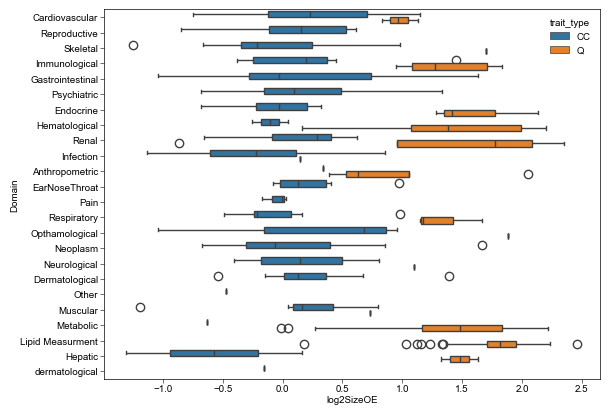

In [159]:
sns.boxplot(type_df, y='Domain', x='log2SizeOE', hue='trait_type')

In [160]:
studies = type_df.StudyR.value_counts()
sns.violinplot(type_df[type_df.StudyR.isin(studies[studies>5].index.values)], x='StudyR', y='log2SizeOE', cut=0)
sns.swarmplot(type_df[type_df.StudyR.isin(studies[studies>5].index.values)], x='StudyR', y='log2SizeOE', hue='trait_type')

AttributeError: 'DataFrame' object has no attribute 'StudyR'

ALL but 5 CC traits are coming from 34375979... In total 207 of the traits are using this one rare study - and seem to be worse than other sources. So I might be able to recover some of these with repeats >> don't just take the study with the highest samples size? >> limitation of working with the UKB. 

<Axes: xlabel='trait_type', ylabel='log2SizeOE'>

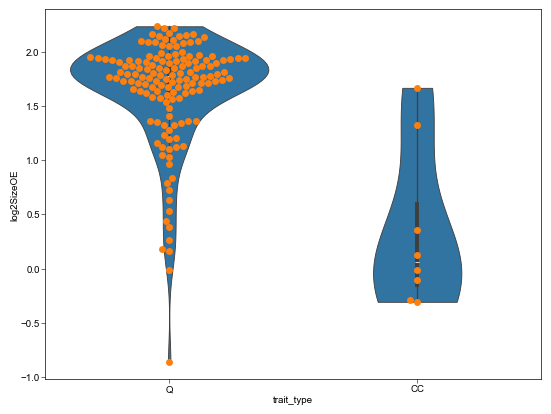

In [29]:
sns.violinplot(type_df[type_df.StudyR!='34375979'], x='trait_type', y='log2SizeOE', cut=0)
sns.swarmplot(type_df[type_df.StudyR!='34375979'], x='trait_type', y='log2SizeOE')

<Axes: xlabel='trait_type', ylabel='log2SizeOE'>

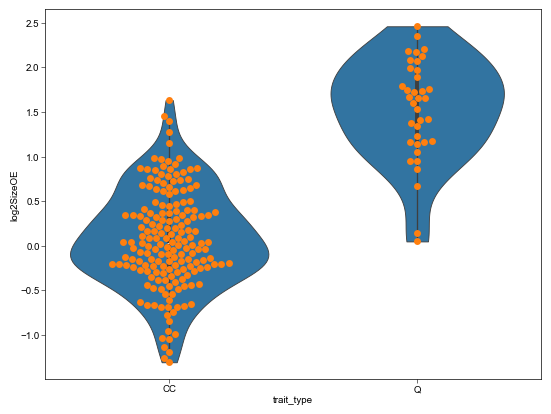

In [30]:
sns.violinplot(type_df[type_df.StudyR=='34375979'], x='trait_type', y='log2SizeOE', cut=0)
sns.swarmplot(type_df[type_df.StudyR=='34375979'], x='trait_type', y='log2SizeOE')

### Domain Manhattan

In [ ]:
man_df = plot_df.copy()

man_df['logp_max'] = man_df['dir_logp'].apply(lambda x: min(x, 50))
order = ['Lipid Measurement', 'Protein Measurement',
       'Hematological Measurement', 'Body Measurement', 'Cardiovascular',
       'Gastro', 'NPD', 'Metabolite Measurement', 'Respiratory', 
       'Eye/Ear/Skin', 'Immune/Infection', 'Endocrine', 'Neoplasm',
       'Skeletal/Connective','Other']
_, [ax1, ax2] = plt.subplots(ncols=1, nrows=2, figsize=(3, 2), sharex=True, gridspec_kw={'hspace':0, 'height_ratios':[5,2.5]})
sns.stripplot(man_df[man_df.log2SizeOE>0], x='Category', y='logp_max', hue='Category', jitter=0.3, s=6,
              palette=['darkblue', 'royalblue']*7+['darkblue'], alpha=0.7, order=order, hue_order=order, ax=ax1)
sns.stripplot(man_df[man_df.log2SizeOE<0], x='Category', y='logp_max', hue='Category', jitter=0.3, s=6,
              palette=['maroon', 'indianred']*7+['maroon'], alpha=0.7, order=order, hue_order=order, ax=ax2)
#sns.boxplot(man_df, x='Category', y='dir_logp', fliersize=0, order=order)
ax2.tick_params(axis='x', rotation=90)
#ax1.set_ylim(0,20)
ax1.hlines(y=3.8, xmin=-0.5, xmax=14.5, color='black',linewidth=0.5, linestyle='--', zorder=100)
ax2.hlines(y=-3.8, xmin=-0.5, xmax=14.5, color='black',linewidth=0.5, linestyle='--', zorder=100)
ax1.tick_params(axis='x', length=0)
ax1.set_xlim(-0.5, 14.5)
ax1.set_ylim(0, 51)
ax2.set_ylim(-25, 0)
ax1.vlines(x=[i+0.5 for i in range(14)], ymin=255, ymax=0, linewidth=0.3, color='grey')
ax2.vlines(x=[i+0.5 for i in range(14)], ymin=-25, ymax=0, linewidth=0.3, color='grey')
_ = ax1.set_yticks([0, 25, 50])
_ = ax2.set_yticks([0, -25], [0, 25])
_ =ax2.set_xticklabels([category_map[x.get_text()] for x in ax2.get_xticklabels()])
plt.savefig(os.path.join(figdir, 'TraitType_Manhattan.svg'), bbox_inches='tight')



## Other Networks

In [37]:
best_df = pd.read_csv(os.path.join(output_dir, 'netcoloc/March_2025','coloc_repeat_best_results.tsv' ), sep='\t')

In [7]:
pc22 = load_files_from_list(os.path.join(output_dir, 'netcoloc/pcnet2_2'), 2262442)

Files loaded 372 Files not found 1


In [9]:
x = 'EFO_0000685'

In [13]:
pc22.loc[[x in y for y in pc22.TraitR.values]]

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,logp_nps,logp_size,log2SizeOE
0,20549515_EFO_0000685,GCST90131437_EFO_0000685,pcnet2_2,neglog10,sum,0.540173,0.069264,0.0,632,187.957,3.887000e-275,250.0,250.0,1.749522


In [16]:
humannet = load_files_from_list(os.path.join(output_dir, 'netcoloc/humannet'), 2262448)

Files loaded 370 Files not found 3


In [81]:
string = load_files_from_list(os.path.join(output_dir, 'netcoloc/string'), 2265165)

Files loaded 350 Files not found 23


In [82]:
df2 = pd.concat([pc22, humannet, string])
df2['EFO'] = df2.TraitR.apply(lambda x: map_trait_code(x))
df2['log2SizeOE'] = np.log2(df2.Size / df2.Null_Size)
df2['logp_nps'] = -1 * np.log10(df2.P_mean_NPS + 1e-250)
df2['logp_size'] = -1 * np.log10(df2.P_size + 1e-250)
df2['trait_pair'] = df2['TraitR'] + '_' + df2['TraitC']

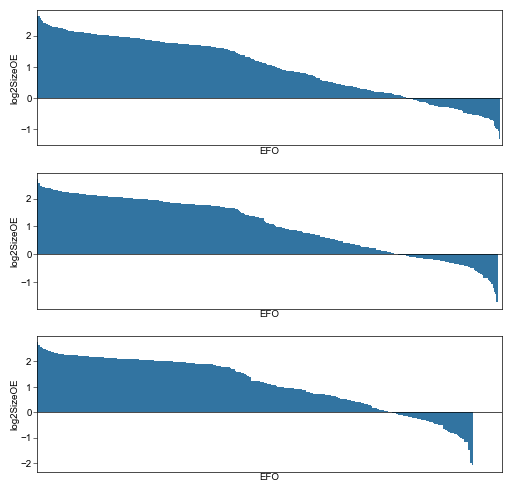

In [84]:
_, [ ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
df2['plot_color'] = df2.logp_size.apply(lambda z: min(z, 50))
for i, net in enumerate(['pcnet2_2', 'humannet', 'stringHC']):
    
    ax = [ax1, ax2, ax3][i]
    sns.barplot(df2[df2.Network==net].sort_values(by='log2SizeOE', ascending=False), x='EFO', y='log2SizeOE', width=1, ax=ax)
    _ = ax.set_xticks([])
    ax.hlines(y=0, xmin=-0.5, xmax=373, color='black', linewidth=0.5)
    ax.set_xlim(-0.5, 373)
#plt.savefig(os.path.join(figdir, 'coloc_test.svg'), bbox_inches='tight')

In [96]:
compare22 = df2[df2.Network=='pcnet2_2'].loc[:, ('trait_pair', 'log2SizeOE', 'logp_size')].merge(best_df.loc[:, ( 'trait_pair', 'log2SizeOE', 'logp_size')],
                                                                 on='trait_pair', suffixes=['22', ''])
compareHN = df2[df2.Network=='humannet'].loc[:, ('trait_pair', 'log2SizeOE', 'logp_size')].merge(best_df.loc[:, ( 'trait_pair', 'log2SizeOE', 'logp_size')],
                                                                 on='trait_pair', suffixes=['HN', ''])
compareST = df2[df2.Network=='stringHC'].loc[:, ('trait_pair', 'log2SizeOE', 'logp_size')].merge(best_df.loc[:, ( 'trait_pair', 'log2SizeOE', 'logp_size')],
                                                                 on='trait_pair', suffixes=['ST', ''])

,log2SizeOE22,logp_size22,log2SizeOE,logp_size
log2SizeOE22,1.000000,0.912585,0.952877,0.901101
logp_size22,0.912585,1.000000,0.887341,0.921850
log2SizeOE,0.952877,0.887341,1.000000,0.927687
logp_size,0.901101,0.921850,0.927687,1.000000


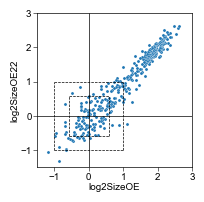

In [86]:
_ = plt.figure(figsize=(2,2))
sns.scatterplot(compare22, x='log2SizeOE', y='log2SizeOE22', s=5)

for x in [-1, -0.58, 0.58, 1]:
    plt.vlines(x=x, ymin=-1*np.abs(x), ymax=np.abs(x), color='black', linewidth=0.5, linestyle='--')
    plt.hlines(y=x, xmin=-1*np.abs(x), xmax=np.abs(x), color='black', linewidth=0.5, linestyle='--')
plt.vlines(x=0, ymin=-1.5, ymax=3,color='black', linewidth=0.5,)
plt.hlines(y=0, xmin=-1.5, xmax=3,color='black', linewidth=0.5,)
plt.xlim(-1.5, 3)
plt.ylim(-1.5, 3)
compare22.corr(numeric_only=True, method='spearman')

,log2SizeOEHN,logp_sizeHN,log2SizeOE,logp_size
log2SizeOEHN,1.000000,0.913066,0.925919,0.876953
logp_sizeHN,0.913066,1.000000,0.879733,0.907217
log2SizeOE,0.925919,0.879733,1.000000,0.927456
logp_size,0.876953,0.907217,0.927456,1.000000


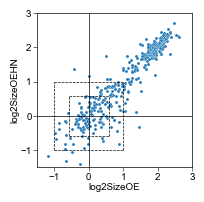

In [87]:
_ = plt.figure(figsize=(2,2))
sns.scatterplot(compareHN, x='log2SizeOE', y='log2SizeOEHN', s=5)

for x in [-1, -0.58, 0.58, 1]:
    plt.vlines(x=x, ymin=-1*np.abs(x), ymax=np.abs(x), color='black', linewidth=0.5, linestyle='--',)
    plt.hlines(y=x, xmin=-1*np.abs(x), xmax=np.abs(x), color='black', linewidth=0.5, linestyle='--',)
plt.vlines(x=0, ymin=-1.5, ymax=3,color='black', linewidth=0.5,)
plt.hlines(y=0, xmin=-1.5, xmax=3,color='black', linewidth=0.5,)
plt.xlim(-1.5, 3)
plt.ylim(-1.5, 3)
compareHN.corr(numeric_only=True, method='spearman')

,log2SizeOEST,logp_sizeST,log2SizeOE,logp_size
log2SizeOEST,1.000000,0.923000,0.924859,0.873330
logp_sizeST,0.923000,1.000000,0.895809,0.902045
log2SizeOE,0.924859,0.895809,1.000000,0.926679
logp_size,0.873330,0.902045,0.926679,1.000000


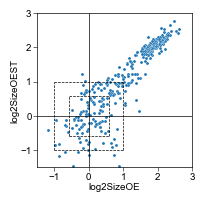

In [91]:
_ = plt.figure(figsize=(2,2))
sns.scatterplot(compareST, x='log2SizeOE', y='log2SizeOEST', s=5)

for x in [-1, -0.58, 0.58, 1]:
    plt.vlines(x=x, ymin=-1*np.abs(x), ymax=np.abs(x), color='black', linewidth=0.5, linestyle='--')
    plt.hlines(y=x, xmin=-1*np.abs(x), xmax=np.abs(x), color='black', linewidth=0.5, linestyle='--')
plt.vlines(x=0, ymin=-1.5, ymax=3,color='black', linewidth=0.5,)
plt.hlines(y=0, xmin=-1.5, xmax=3,color='black', linewidth=0.5,)
plt.xlim(-1.5, 3)
plt.ylim(-1.5, 3)
compareST.corr(numeric_only=True, method='spearman')

In [135]:
all_compare = best_df.loc[:, ( 'trait_pair', 'log2SizeOE', 'logp_size')].merge(df2[df2.Network=='pcnet2_2'].loc[:, ('trait_pair', 'log2SizeOE', 'logp_size')],
                                                                              on='trait_pair', suffixes=['', '22'], how='left')
all_compare = all_compare.merge(df2[df2.Network=='humannet'].loc[:, ('trait_pair', 'log2SizeOE', 'logp_size')],
                               on='trait_pair', suffixes=['', 'HN'], how='left')
all_compare = all_compare.merge(df2[df2.Network=='stringHC'].loc[:, ('trait_pair', 'log2SizeOE', 'logp_size')],
                               on='trait_pair', suffixes=['', 'ST'], how='left')

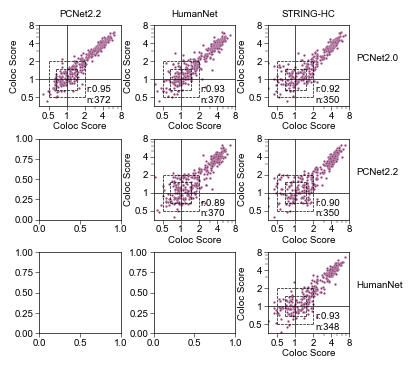

In [151]:
_, axs = plt.subplots(nrows=3, ncols=3, figsize=(4,4), sharex=False, sharey=False, gridspec_kw={'hspace':0.4, 'wspace':0.4})

nets = ['', '22', 'HN', 'ST']
net_names = {'':'PCNet2.0', '22':'PCNet2.2', 'HN':'HumanNet', 'ST': 'STRING-HC'}
R = all_compare.corr(method='spearman', numeric_only=True)

for i, n1 in enumerate(nets[:-1]):
    for j, n2 in enumerate(nets[1+i:]): 
        if n1 != n2:
            ax = axs[i][j+i]
            sns.scatterplot(all_compare, x=f'log2SizeOE{n2}', y=f'log2SizeOE{n1}', s=3, ax=ax, color='#8D3B72', alpha=1)
            n = all_compare.loc[:, (f'log2SizeOE{n2}', f'log2SizeOE{n1}')].dropna().shape
            ax.vlines(x=0, ymin=-1.5, ymax=3,color='black', linewidth=0.5,)
            ax.hlines(y=0, xmin=-1.5, xmax=3,color='black', linewidth=0.5,)
            for x in [-1, -0.58, 0.58, 1]:
                ax.vlines(x=x, ymin=-1*np.abs(x), ymax=np.abs(x), color='black', linewidth=0.5, linestyle='--')
                ax.hlines(y=x, xmin=-1*np.abs(x), xmax=np.abs(x), color='black', linewidth=0.5, linestyle='--')
            ax.set_xlim(-1.5, 3)
            ax.set_ylim(-1.5, 3)
            r = R.at[f'log2SizeOE{n1}', f'log2SizeOE{n2}']
            ax.text(1.1, -1.3, s=f'r:{r:.2f}\nn:{n[0]}')
            ax.set_ylabel('Coloc Score')
            ax.set_xlabel('Coloc Score')
            ax.set_yticks([-1, 0, 1, 2, 3], labels=[0.5, 1, 2, 4, 8])
            _ = ax.set_yticks(np.log2([3,5,6, 7]), minor=True)
            ax.set_xticks([-1, 0, 1, 2, 3], labels=[0.5, 1, 2, 4, 8])
            _ = ax.set_xticks(np.log2([3,5,6, 7]), minor=True)
            if i == 0:
                ax.set_title(net_names[n2], fontsize=7)
            if j + i == 2:
                ax.text(3.4, 1, net_names[n1], fontsize=7)

plt.savefig(os.path.join(figdir, 'other_network_correlations.svg'), bbox_inches='tight')

In [158]:
for i in range(6):
    print(i%3, i%2)

0 0
1 1
2 0
0 1
1 0
2 1


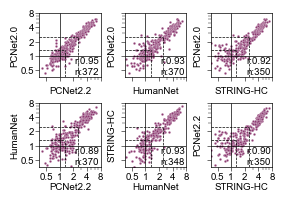

In [186]:
_, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(nrows=2, ncols=3, figsize=(3,2), sharex=False, sharey=False, gridspec_kw={'hspace':0.4, 'wspace':0.4})

nets = ['', '22', 'HN', 'ST']
net_names = {'':'PCNet2.0', '22':'PCNet2.2', 'HN':'HumanNet', 'ST': 'STRING-HC'}
R = all_compare.corr(method='spearman', numeric_only=True)

pairs = [('', '22'), ('', 'HN'), ('', 'ST'), ('HN', '22'), ('ST', 'HN'), ('22', 'ST')]
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

for i, p in enumerate(pairs):
    ax = axs[i]
    n1=p[0]
    n2=p[1]
    sns.scatterplot(all_compare, x=f'log2SizeOE{n2}', y=f'log2SizeOE{n1}', s=3, ax=ax, color='#8D3B72', alpha=1)
    n = all_compare.loc[:, (f'log2SizeOE{n2}', f'log2SizeOE{n1}')].dropna().shape
    ax.vlines(x=0, ymin=-1.5, ymax=3,color='black', linewidth=0.5,)
    ax.hlines(y=0, xmin=-1.5, xmax=3,color='black', linewidth=0.5,)
    for x in [np.log2(1.3), np.log2(2.5)]:
        ax.vlines(x=x, ymin=-1.5, ymax=np.abs(x), color='black', linewidth=0.5, linestyle='--')
        ax.hlines(y=x, xmin=-1.5, xmax=np.abs(x), color='black', linewidth=0.5, linestyle='--')
    ax.set_xlim(-1.5, 3)
    ax.set_ylim(-1.5, 3)
    r = R.at[f'log2SizeOE{n1}', f'log2SizeOE{n2}']
    ax.text(1.1, -1.3, s=f'r:{r:.2f}\nn:{n[0]}')
    ax.set_ylabel(net_names[n1])
    ax.set_xlabel(net_names[n2])
    if i in [0, 3]:
        ax.set_yticks([-1, 0, 1, 2, 3], labels=[0.5, 1, 2, 4, 8])
        _ = ax.set_yticks(np.log2([3,5,6, 7]), minor=True)
    else:
        ax.set_yticks([-1, 0, 1, 2, 3], labels=[])
        _ = ax.set_yticks(np.log2([3,5,6, 7]), minor=True)
    if i>= 3:
        ax.set_xticks([-1, 0, 1, 2, 3], labels=[0.5, 1, 2, 4, 8])
        _ = ax.set_xticks(np.log2([3,5,6, 7]), minor=True)
    else:
        ax.set_xticks([-1, 0, 1, 2, 3], labels=[])
        _ = ax.set_xticks(np.log2([3,5,6, 7]), minor=True)
plt.savefig(os.path.join(figdir, 'other_network_correlations_3_2.svg'), bbox_inches='tight')

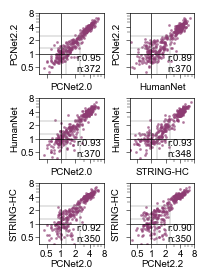

In [190]:
_, [[ax1, ax4],[ax2, ax5], [ax3,ax6]] = plt.subplots(nrows=3, ncols=2, figsize=(2,3), sharex=False, sharey=False, gridspec_kw={'hspace':0.4, 'wspace':0.4})

nets = ['', '22', 'HN', 'ST']
net_names = {'':'PCNet2.0', '22':'PCNet2.2', 'HN':'HumanNet', 'ST': 'STRING-HC'}
R = all_compare.corr(method='spearman', numeric_only=True)

pairs = [('', '22'), ('', 'HN'), ('', 'ST'), ('HN', '22'), ('ST', 'HN'), ('22', 'ST')]
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

for i, p in enumerate(pairs):
    ax = axs[i]
    n1=p[1]
    n2=p[0]
    sns.scatterplot(all_compare, x=f'log2SizeOE{n2}', y=f'log2SizeOE{n1}', s=3, ax=ax, color='#8D3B72', alpha=0.7, edgecolor=None)
    n = all_compare.loc[:, (f'log2SizeOE{n2}', f'log2SizeOE{n1}')].dropna().shape
    ax.vlines(x=0, ymin=-1.5, ymax=3,color='black', linewidth=0.5,)
    ax.hlines(y=0, xmin=-1.5, xmax=3,color='black', linewidth=0.5,)
    for x in [np.log2(1.3), np.log2(2.5)]:
        ax.vlines(x=x, ymin=-1.5, ymax=np.abs(x), color='grey', linewidth=0.3, linestyle='-')
        ax.hlines(y=x, xmin=-1.5, xmax=np.abs(x), color='grey', linewidth=0.3, linestyle='-')
    ax.set_xlim(-1.5, 3)
    ax.set_ylim(-1.5, 3)
    r = R.at[f'log2SizeOE{n1}', f'log2SizeOE{n2}']
    ax.text(1.1, -1.3, s=f'r:{r:.2f}\nn:{n[0]}')
    ax.set_ylabel(net_names[n1])
    ax.set_xlabel(net_names[n2])
    if i <3:
        ax.set_yticks([-1, 0, 1, 2, 3], labels=[0.5, 1, 2, 4, 8])
        _ = ax.set_yticks(np.log2([3,5,6, 7]), minor=True)
    else:
        ax.set_yticks([-1, 0, 1, 2, 3], labels=[])
        _ = ax.set_yticks(np.log2([3,5,6, 7]), minor=True)
    if i in [2,5]:
        ax.set_xticks([-1, 0, 1, 2, 3], labels=[0.5, 1, 2, 4, 8])
        _ = ax.set_xticks(np.log2([3,5,6, 7]), minor=True)
    else:
        ax.set_xticks([-1, 0, 1, 2, 3], labels=[])
        _ = ax.set_xticks(np.log2([3,5,6, 7]), minor=True)
plt.savefig(os.path.join(figdir, 'other_network_correlations_2_3.svg'), bbox_inches='tight')

IndexError: index 2 is out of bounds for axis 0 with size 2

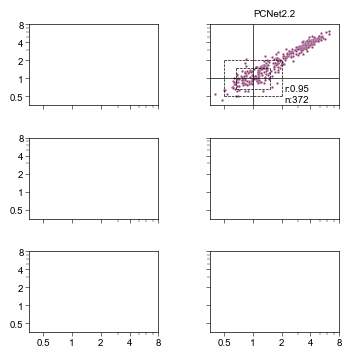

In [153]:
for i, n1 in enumerate(nets[:-1]):
    for j, n2 in enumerate(nets[i:]): 
        if n1 != n2:
            ax = axs[i][j+i]
            sns.scatterplot(all_compare, x=f'log2SizeOE{n2}', y=f'log2SizeOE{n1}', s=3, ax=ax, color='#8D3B72', alpha=1)
            n = all_compare.loc[:, (f'log2SizeOE{n2}', f'log2SizeOE{n1}')].dropna().shape
            ax.vlines(x=0, ymin=-1.5, ymax=3,color='black', linewidth=0.5,)
            ax.hlines(y=0, xmin=-1.5, xmax=3,color='black', linewidth=0.5,)
            for x in [-1, -0.58, 0.58, 1]:
                ax.vlines(x=x, ymin=-1*np.abs(x), ymax=np.abs(x), color='black', linewidth=0.5, linestyle='--')
                ax.hlines(y=x, xmin=-1*np.abs(x), xmax=np.abs(x), color='black', linewidth=0.5, linestyle='--')
            ax.set_xlim(-1.5, 3)
            ax.set_ylim(-1.5, 3)
            r = R.at[f'log2SizeOE{n1}', f'log2SizeOE{n2}']
            ax.text(1.1, -1.3, s=f'r:{r:.2f}\nn:{n[0]}')
            ax.set_ylabel('Coloc Score')
            ax.set_xlabel('Coloc Score')
            ax.set_yticks([-1, 0, 1, 2, 3], labels=[0.5, 1, 2, 4, 8])
            _ = ax.set_yticks(np.log2([3,5,6, 7]), minor=True)
            ax.set_xticks([-1, 0, 1, 2, 3], labels=[0.5, 1, 2, 4, 8])
            _ = ax.set_xticks(np.log2([3,5,6, 7]), minor=True)
            if i == 0:
                ax.set_title(net_names[n2], fontsize=7)
            if j + i == 2:
                ax.text(3.4, 1, net_names[n1], fontsize=7)

#plt.savefig(os.path.join(figdir, 'other_network_correlations.svg'), bbox_inches='tight')

### UKB - GWASAtlas/Genebass

In [18]:
## need to prioritize the repeated studies by cosine/N for initial set.
df_ukb = pd.read_csv(os.path.join(output_dir, 'netcoloc/UKB', 'rvc_qnetcoloc_gb_ga.txt'), sep='\t', header=None,
                names =['TraitR', 'TraitC', 'Network','Transform', 'Norm','Mean_NPS', 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ])
df_ukb['log2SizeOE'] = np.log2(df_ukb.Size / df_ukb.Null_Size)
df_ukb['logp_nps'] = -1 * np.log10(df_ukb.P_mean_NPS + 1e-250)
df_ukb['logp_size'] = -1 * np.log10(df_ukb.P_size + 1e-250)
df_ukb['trait_pair'] = df_ukb['TraitR'] + '_' + df_ukb['TraitC']

In [47]:
df_ukb.nunique()

TraitR           182
TraitC           129
Network            1
Transform          1
Norm               1
Mean_NPS         258
Null_mean_NPS    258
P_mean_NPS       257
Size             186
Null_Size        257
P_size           257
log2SizeOE       258
logp_nps         254
logp_size        257
trait_pair       258
dtype: int64

In [27]:
## need to prioritize the repeated studies by cosine/N for initial set.
df_ukb256 = pd.read_csv(os.path.join(output_dir, 'netcoloc/UKB', 'rvc_qnetcoloc_256_gb_ga.txt'), sep='\t', header=None,
                names =['TraitR', 'TraitC', 'Network','Transform', 'Norm','Mean_NPS', 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ])
df_ukb256['log2SizeOE'] = np.log2(df_ukb256.Size / df_ukb256.Null_Size)
df_ukb256['logp_nps'] = -1 * np.log10(df_ukb256.P_mean_NPS + 1e-250)
df_ukb256['logp_size'] = -1 * np.log10(df_ukb256.P_size + 1e-250)
df_ukb256['trait_pair'] = df_ukb256['TraitR'] + '_' + df_ukb256['TraitC']

In [28]:
df_ukb256.shape

(129, 15)

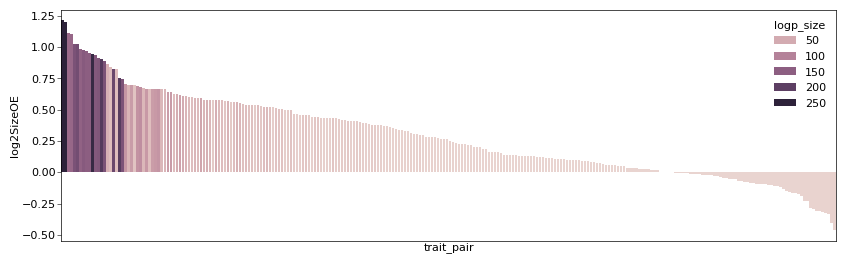

In [34]:
_ = plt.figure(figsize=(10, 3))
sns.barplot(df_ukb.sort_values(by='log2SizeOE', ascending=False), x='trait_pair', y='log2SizeOE', hue='logp_size')
_ = plt.xticks([])

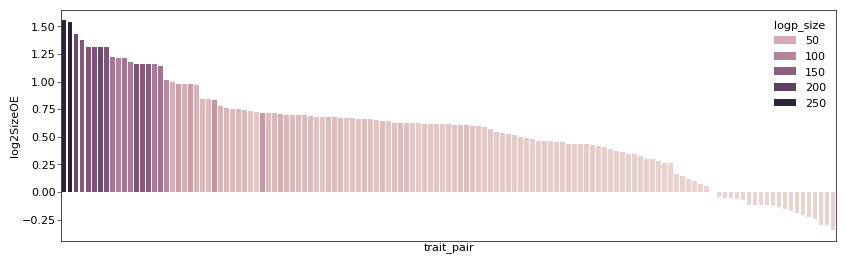

In [35]:
_ = plt.figure(figsize=(10, 3))
sns.barplot(df_ukb256.sort_values(by='log2SizeOE', ascending=False), x='trait_pair', y='log2SizeOE', hue='logp_size')
_ = plt.xticks([])

In [46]:
df_ukb256.drop_duplicates(subset=['TraitC']).drop_duplicates(subset=['TraitR'])

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,log2SizeOE,logp_nps,logp_size,trait_pair
0,GB_UKB_idx2474_phe6150_256,GA_idx4377_UK2_30940143_256,pcnet2_0,neglog10,sum,0.199261,0.003104,5.308000e-116,309,192.457,1.652000e-21,0.683071,115.275069,20.781990,GB_UKB_idx2474_phe6150_256_GA_idx4377_UK2_3094...
1,GB_UKB_idx2595_phe102_256,GA_idx3187_UK2_31427789_256,pcnet2_0,neglog10,sum,0.344464,0.011735,0.000000e+00,465,200.431,1.037000e-104,1.214125,250.000000,103.984221,GB_UKB_idx2595_phe102_256_GA_idx3187_UK2_31427...
2,GB_UKB_idx2599_phe1239_256,GA_idx3234_UK2_31427789_256,pcnet2_0,neglog10,sum,0.083532,-0.004682,1.612000e-28,278,252.040,6.025000e-02,0.141432,27.792635,1.220043,GB_UKB_idx2599_phe1239_256_GA_idx3234_UK2_3142...
3,GB_UKB_idx2618_phe1269_256,GA_idx3237_UK2_31427789_256,pcnet2_0,neglog10,sum,-0.029213,-0.000584,6.119000e-04,298,286.344,4.429000e-01,0.057563,3.213320,0.353694,GB_UKB_idx2618_phe1269_256_GA_idx3237_UK2_3142...
5,GB_UKB_idx2622_phe1687_256,GA_idx3269_UK2_31427789_256,pcnet2_0,neglog10,sum,0.177455,0.015460,3.060000e-81,331,165.656,8.262000e-48,0.998641,80.514279,47.082915,GB_UKB_idx2622_phe1687_256_GA_idx3269_UK2_3142...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,GB_UKB_idx3760_phechronotype_1180_quant_256,GA_idx1140_UKB1_27494321_256,pcnet2_0,neglog10,sum,0.090144,0.000344,5.230000e-41,226,183.374,7.659000e-04,0.301534,40.281498,3.115828,GB_UKB_idx3760_phechronotype_1180_quant_256_GA...
125,GB_UKB_idx933_phe2443_256,GA_idx3327_UK2_31427789_256,pcnet2_0,neglog10,sum,0.050387,-0.020917,9.029000e-24,272,197.989,8.849000e-09,0.458186,23.044360,8.053106,GB_UKB_idx933_phe2443_256_GA_idx3327_UK2_31427...
126,GB_UKB_idx934_phe2453_256,GA_idx3328_UK2_31427789_256,pcnet2_0,neglog10,sum,0.512202,0.011275,0.000000e+00,734,411.119,4.397000e-79,0.836224,250.000000,78.356844,GB_UKB_idx934_phe2453_256_GA_idx3328_UK2_31427...
127,GB_UKB_idx936_phe2724_256,GA_idx3339_UK2_31427789_256,pcnet2_0,neglog10,sum,0.109342,-0.001419,5.617000e-36,370,230.495,4.242000e-23,0.682790,35.250496,22.372429,GB_UKB_idx936_phe2724_256_GA_idx3339_UK2_31427...


# January 2025

In [5]:
df = pd.read_csv(os.path.join(output_dir, 'netcoloc/Jan_2025', 'rvc_qnetcoloc_results_v2.txt'), sep='\t', header=None,
                names =['TraitR', 'TraitC', 'Network','Transform', 'Norm','Mean_NPS', 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ])
df['EFO'] = df.TraitR.apply(lambda x: map_trait_code(x))
df['StudyC'] = df.TraitC.apply(lambda x: next((match.group() for match in re.finditer(r'GCST\d+', x)), None))
df['StudyR'] = df.TraitR.apply(lambda x: x.split('_')[0])
df['log2SizeOE'] = np.log2(df.Size / df.Null_Size)
df['logp_nps'] = -1 * np.log10(df.P_mean_NPS + 1e-250)
df['logp_size'] = -1 * np.log10(df.P_size + 1e-250)

In [6]:
df['trait_pair'] = df['TraitR'] + '_' + df['TraitC']

In [7]:
r_traitlist = pd.read_csv(os.path.join(datadir, 'inputs/Jan_2025', 'rare.traitlist2'), header=None)[0].values
c_traitlist = pd.read_csv(os.path.join(datadir, 'inputs/Jan_2025', 'common.traitlist2'), header=None)[0].values
pairs = [r_traitlist[i]+'_'+c_traitlist[i] for i in range(len(r_traitlist))]

In [8]:
df = df[df.trait_pair.isin(pairs)]

In [9]:
df.EFO.nunique()


320

In [10]:
df.head()

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,EFO,StudyC,StudyR,log2SizeOE,logp_nps,logp_size,trait_pair
10,20549515.0_EFO_0000384,GCST90446792_EFO_0000384,pcnet2_0,neglog10,sum,0.457410,0.021414,0.000000e+00,764,224.938,0.000000e+00,EFO_0000384,GCST90446792,20549515.0,1.764045,250.000000,250.000000,20549515.0_EFO_0000384_GCST90446792_EFO_0000384
14,20549515.0_EFO_0000685,GCST90018910_EFO_0000685,pcnet2_0,neglog10,sum,0.329865,0.004017,0.000000e+00,434,210.115,9.485000e-65,EFO_0000685,GCST90018910,20549515.0,1.046516,250.000000,64.022963,20549515.0_EFO_0000685_GCST90018910_EFO_0000685
25,20691247.0_EFO_0004825,GCST001531_EFO_0004825,pcnet2_0,neglog10,sum,0.437280,0.001383,0.000000e+00,748,291.007,2.078000e-195,EFO_0004825,GCST001531,20691247.0,1.361984,250.000000,194.682354,20691247.0_EFO_0004825_GCST001531_EFO_0004825
31,20876667.0_EFO_0000765,GCST001060_EFO_0000765,pcnet2_0,neglog10,sum,0.148887,-0.001976,3.859000e-111,299,162.982,2.788000e-31,EFO_0000765,GCST001060,20876667.0,0.875433,110.413525,30.554707,20876667.0_EFO_0000765_GCST001060_EFO_0000765
42,23263489.0_EFO_0009961,GCST008110_EFO_0009961,pcnet2_0,neglog10,sum,0.573017,0.015954,0.000000e+00,1045,178.560,0.000000e+00,EFO_0009961,GCST008110,23263489.0,2.549022,250.000000,250.000000,23263489.0_EFO_0009961_GCST008110_EFO_0009961


## Other similarities

In [11]:
## dot product similarity
def similarities(traitR, traitC, datadir, transform='neglog10', norm='sum'):
    df_r = load_z(traitR, datadir, transform, norm, rorc='R')
    df_c = load_z(traitC, datadir, transform, norm, rorc='C')
    df = df_r.join(df_c, lsuffix='r', rsuffix='c', how='inner')
    dot_product_similarity = np.dot(df.zr, df.zc)
    return dot_product_similarity, dot_product_similarity/(df.zr.sum() * df.zc.sum()) 
    
def load_z(trait, datadir, transform, norm, rorc):
    df = pd.read_csv(os.path.join(datadir, f'{trait}_z_{rorc}V_q_{transform}_{norm}.tsv'), sep='\t', header=None,
                    index_col=0, names=['z']).dropna()
    return df

In [23]:
dots = []
cosines = []
for i, pair in tqdm(enumerate(zip(df.TraitR, df.TraitC))):
    dot, cos = similarities(pair[0], pair[1], os.path.join(output_dir, 'netcoloc/Jan_2025'))
    dots.append(dot)
    cosines.append(cos)
df['dot_product'] = dots
df['cosine'] = cosines

1650it [01:46, 15.43it/s]


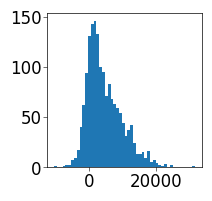

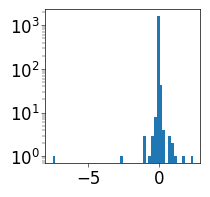

In [24]:
_ = plt.figure(figsize=(2,2))
_ = plt.hist(df.dot_product, bins=50)
_ = plt.figure(figsize=(2,2))
_ = plt.hist(df.cosine, bins=50)
plt.yscale('log')

## Prioritization of additional genes

In [12]:
## Load all_zscores
def load_all_scores(datadir, rorc):
    allz = {}
    if rorc == 'C':
        other = 'TraitR'
    else:
        other = 'TraitC'
    for i, t in tqdm(enumerate(list(df[f'Trait{rorc}'].values))):
        if rorc == 'R':
            other = 'TraitC'
            allz[f'{t}_{df[other].values[i]}'] = load_z(t, datadir, 'neglog10', 'sum', rorc=rorc).z.to_dict()
        else:
            other = 'TraitR'
            allz[f'{df[other].values[i]}_{t}'] = load_z(t, datadir, 'neglog10', 'sum', rorc=rorc).z.to_dict()
    z = pd.DataFrame.from_dict(allz)
    return z

In [1]:
zR = load_all_scores(os.path.join(output_dir, 'netcoloc/Jan_2025'), 'R').dropna()
zC = load_all_scores(os.path.join(output_dir, 'netcoloc/Jan_2025'), 'C').dropna()
z_coloc = zR * zC

NameError: name 'load_all_scores' is not defined

In [14]:
## Load genes
def load_genes(trait, rorc, indir=os.path.join(output_dir, '../inputs/Jan_2025')):
    genes = pd.read_csv(os.path.join(indir, trait+f'_{rorc}V.txt'), sep='\t')
    return genes['Entrez'].unique()

network_genes = list(z_coloc.index.values)
rare_genes = {t: [x for x in load_genes(t, 'R') if x in network_genes] for t in tqdm(df.TraitR.unique())}
common_genes = {t: [x for x in load_genes(t, 'C') if x in network_genes] for t in tqdm(df.TraitC.unique())}

100%|██████████| 320/320 [00:10<00:00, 31.06it/s] 


In [15]:
trait_pairs = [x for x in zip(df.TraitR, df.TraitC)]

overlap_genes = {t:set(rare_genes[t[0]]).intersection(common_genes[t[1]]) for t in tqdm(trait_pairs)}
rare_only = {t:set(rare_genes[t[0]]).difference(common_genes[t[1]]) for t in tqdm(trait_pairs)}
common_only = {t:set(common_genes[t[1]]).difference(rare_genes[t[0]]) for t in tqdm(trait_pairs)}

100%|██████████| 320/320 [00:00<00:00, 145635.56it/s]


In [16]:
gene_splits = pd.DataFrame({'Overlap':[len(overlap_genes[x]) for x in trait_pairs], 
                           'RareOnly':[len(rare_only[x]) for x in trait_pairs],
                           'CommonOnly':[len(common_only[x]) for x in trait_pairs]}, index=trait_pairs)
gene_splits['TraitR'] = [t[0] for t in trait_pairs]
gene_splits['TraitC'] = [t[1] for t in trait_pairs]
gene_splits['EFO'] = gene_splits.TraitR.apply(lambda x: map_trait_code(x))

In [17]:
def get_single_z_support(idx, genes, data_df, th=3):
    trait_df = data_df.iloc[:, idx]
    gene_df = trait_df.loc[list(genes)]
    return np.sum(gene_df >= th)

def get_coloc_support(trait, genes, rare_df, common_df, th=3):
    trait_rare = rare_df[trait]
    trait_common = common_df[trait]
    trait_df = pd.DataFrame({'rare':trait_rare, 'common':trait_common}).loc[list(genes)]
    trait_df['coloc'] = trait_df.rare * trait_df.common
    return len(trait_df[(trait_df.coloc >= th) & (trait_df.rare > 1) & (trait_df.common > 1)])

def get_all_support(trait_pairs, rare_df, common_df, coloc_df):
    
    results = {'Overlap':{}, 'Rare':{}, 'Common':{}}
    for i, pair in tqdm(enumerate(trait_pairs)):
        for j, geneset in enumerate([overlap_genes[pair], rare_only[pair], common_only[pair]]):

            rare_n = get_single_z_support(i,geneset, rare_df, th=1)
            common_n = get_single_z_support(i,geneset, common_df, th=1)
            coloc_n = get_single_z_support(i,geneset,coloc_df, th=3)
            results[['Overlap', 'Rare', 'Common'][j]][pair] = {'Zr':rare_n, 'Zc':common_n, 'Zrc':coloc_n}
        
        #for i, geneset in enumerate([overlap_genes, rare_only, common_only]):
         #   rare_n = get_single_z_support(t[0], geneset[t], rare_df)
          #  common_n = get_single_z_support(t[1], geneset[t], common_df)
           # coloc_n = get_coloc_support(t, geneset[t], rare_df, common_df)
           # results[['Overlap', 'Rare', 'Common'][i]][t] = {'Zr':rare_n, 'Zc':common_n, 'Zrc':coloc_n}
    return results

In [18]:
results_dict = get_all_support(trait_pairs, zR, zC, z_coloc)

320it [00:00, 338.80it/s]


In [19]:
results_overlap = pd.DataFrame.from_dict(results_dict['Overlap'], orient='index').reset_index(names=['TraitR', 'TraitC'])
results_rare = pd.DataFrame.from_dict(results_dict['Rare'], orient='index').reset_index(names=['TraitR', 'TraitC'])
results_common = pd.DataFrame.from_dict(results_dict['Common'], orient='index').reset_index(names=['TraitR', 'TraitC'])
results_rare.columns = ['Rare_'+x if 'Z' in x else x for x in  results_rare.columns]
results_common.columns = ['Common_'+x if 'Z' in x else x for x in  results_common.columns]

In [20]:
gene_split_results = gene_splits.merge(results_rare, on=['TraitR', 'TraitC']).merge(results_common, on=['TraitR', 'TraitC'])

In [21]:
(gene_split_results.drop_duplicates(subset=['TraitC']).Common_Zrc / gene_split_results.drop_duplicates(subset=['TraitC']).CommonOnly).describe()


count    319.000000
mean       0.282302
std        0.225898
min        0.000000
25%        0.125000
50%        0.252000
75%        0.400000
max        1.000000
dtype: float64

In [22]:
(gene_split_results.drop_duplicates(subset=['TraitR']).Rare_Zrc / gene_split_results.drop_duplicates(subset=['TraitR']).RareOnly).describe()

count    318.000000
mean       0.325870
std        0.242729
min        0.000000
25%        0.158962
50%        0.255814
75%        0.468229
max        1.000000
dtype: float64

In [23]:
gene_splits['overlap+rare'] = gene_splits['Overlap'] + gene_splits['RareOnly']
gene_splits['Total'] = gene_splits['overlap+rare'] + gene_splits['CommonOnly']
gene_splits = gene_splits.sort_values(by=['Overlap', 'overlap+rare', 'Total'], ascending=False)

In [24]:
gene_splits['trait_pair'] = gene_splits['TraitR'] + '_' + gene_splits['TraitC']

In [25]:
gene_splits.head(20)

,Overlap,RareOnly,CommonOnly,TraitR,TraitC,EFO,overlap+rare,Total,trait_pair
"(33230300.0_EFO_0005763, GCST90310296_EFO_0005763)",25,51,571,33230300.0_EFO_0005763,GCST90310296_EFO_0005763,EFO_0005763,76,647,33230300.0_EFO_0005763_GCST90310296_EFO_0005763
"(34226706.0_EFO_0007986, GCST90025970_EFO_0007986)",17,36,3,34226706.0_EFO_0007986,GCST90025970_EFO_0007986,EFO_0007986,53,56,34226706.0_EFO_0007986_GCST90025970_EFO_0007986
"(33230300.0_EFO_0006336, GCST90449057_EFO_0006336)",17,32,441,33230300.0_EFO_0006336,GCST90449057_EFO_0006336,EFO_0006336,49,490,33230300.0_EFO_0006336_GCST90449057_EFO_0006336
"(33230300.0_EFO_0006335, GCST90449056_EFO_0006335)",16,41,447,33230300.0_EFO_0006335,GCST90449056_EFO_0006335,EFO_0006335,57,504,33230300.0_EFO_0006335_GCST90449056_EFO_0006335
"(36809768.0_EFO_0020946, GCST90269691_EFO_0020946)",14,224,9,36809768.0_EFO_0020946,GCST90269691_EFO_0020946,EFO_0020946,238,247,36809768.0_EFO_0020946_GCST90269691_EFO_0020946
"(36809768.0_EFO_0008317, GCST90302157_EFO_0008317)",13,175,16,36809768.0_EFO_0008317,GCST90302157_EFO_0008317,EFO_0008317,188,204,36809768.0_EFO_0008317_GCST90302157_EFO_0008317
"(36809768.0_EFO_0008595, GCST90301982_EFO_0008595)",13,68,20,36809768.0_EFO_0008595,GCST90301982_EFO_0008595,EFO_0008595,81,101,36809768.0_EFO_0008595_GCST90301982_EFO_0008595
"(36809768.0_EFO_0010733, GCST90302071_EFO_0010733)",11,36,20,36809768.0_EFO_0010733,GCST90302071_EFO_0010733,EFO_0010733,47,67,36809768.0_EFO_0010733_GCST90302071_EFO_0010733
"(24728188.0_EFO_0000612, GCST90018877_EFO_0000612)",11,27,25,24728188.0_EFO_0000612,GCST90018877_EFO_0000612,EFO_0000612,38,63,24728188.0_EFO_0000612_GCST90018877_EFO_0000612
"(34662886.0_EFO_0007989, GCST90002394_EFO_0007989)",11,3,260,34662886.0_EFO_0007989,GCST90002394_EFO_0007989,EFO_0007989,14,274,34662886.0_EFO_0007989_GCST90002394_EFO_0007989


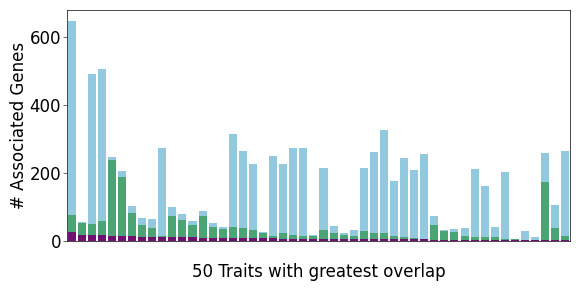

In [55]:
_ = plt.figure(figsize=(6.5, 3))
sns.barplot(gene_splits[gene_splits.Total<1000][0:50], x='trait_pair', y='Overlap', color='purple', zorder=10, )
sns.barplot(gene_splits[gene_splits.Total<1000][0:50], x='trait_pair', y='overlap+rare', color='mediumseagreen', zorder=5, )
sns.barplot(gene_splits[gene_splits.Total<1000][0:50], x='trait_pair', y='Total', color='skyblue', zorder=1, )
_ = plt.xticks([])
plt.ylabel('# Associated Genes')
plt.xlabel('\n50 Traits with greatest overlap')
plt.savefig(os.path.join(figdir, 'overlap_bar_before.jpg'), dpi=400, bbox_inches='tight')

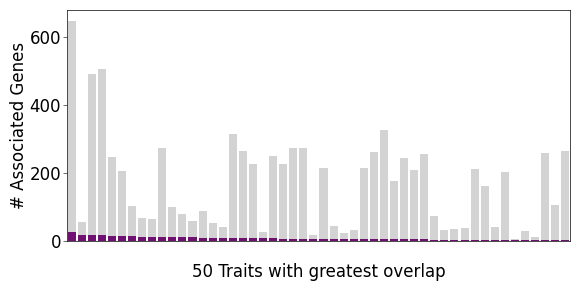

In [54]:
_ = plt.figure(figsize=(6.5, 3))
sns.barplot(gene_splits[gene_splits.Total<1000][0:50], x='trait_pair', y='Overlap', color='purple', zorder=10, )
sns.barplot(gene_splits[gene_splits.Total<1000][0:50], x='trait_pair', y='overlap+rare', color='lightgrey', zorder=5, )
sns.barplot(gene_splits[gene_splits.Total<1000][0:50], x='trait_pair', y='Total', color='lightgrey', zorder=1, )
_ = plt.xticks([])
plt.ylabel('# Associated Genes')
plt.xlabel('\n50 Traits with greatest overlap')
plt.savefig(os.path.join(figdir, 'overlap_bar_overlap_only.jpg'), dpi=400, bbox_inches='tight')

In [26]:
#gene_split_results['trait'] = gene_split_results.index
gene_split_results['trait_pair'] = gene_split_results['TraitR'] + '_' + gene_split_results['TraitC']
gene_split_results['overlap+rare'] = gene_split_results['Overlap'] + gene_split_results['RareOnly']
gene_split_results['Total'] = gene_split_results['overlap+rare'] + gene_split_results['CommonOnly']
gene_split_results['overlap+RareZ'] = gene_split_results['Overlap'] + gene_split_results['Rare_Zrc']
gene_split_results['overlap+RareCommonZ'] = gene_split_results['overlap+RareZ'] + gene_split_results['Common_Zrc']
gene_split_results = gene_split_results.sort_values(by=['Overlap', 'overlap+rare', 'Total'], ascending=False)

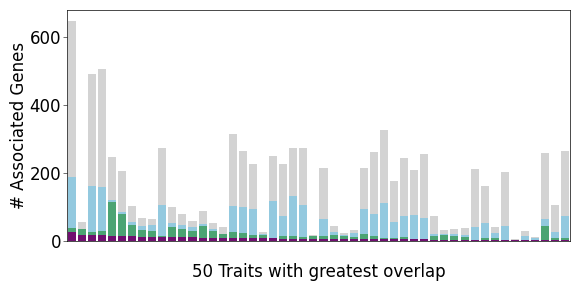

In [53]:
_ = plt.figure(figsize=(6.5, 3))
sns.barplot(gene_split_results[gene_split_results.Total<1000][0:50], x='trait_pair', y='Overlap', color='purple', zorder=10,)
sns.barplot(gene_split_results[gene_split_results.Total<1000][0:50], x='trait_pair', y='overlap+RareZ', color='mediumseagreen', zorder=5)
sns.barplot(gene_split_results[gene_split_results.Total<1000][0:50], x='trait_pair', y='overlap+RareCommonZ', color='skyblue', zorder=3)
sns.barplot(gene_split_results[gene_split_results.Total<1000][0:50], x='trait_pair', y='Total', color='lightgrey', zorder=1, saturation=1)
_ = plt.xticks([])
plt.ylabel('# Associated Genes')
plt.xlabel('\n50 Traits with greatest overlap')
plt.savefig(os.path.join(figdir, 'overlap_bar_after.jpg'), dpi=400, bbox_inches='tight')

Text(0.5, 0, '')

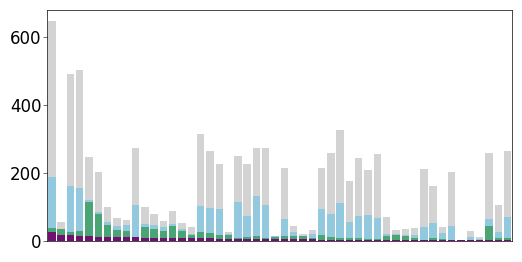

In [41]:
_ = plt.figure(figsize=(6, 3))
sns.barplot(gene_split_results[0:50], x='trait_pair', y='Overlap', color='purple', zorder=10,)
sns.barplot(gene_split_results[0:50], x='trait_pair', y='overlap+RareZ', color='mediumseagreen', zorder=5)
sns.barplot(gene_split_results[0:50], x='trait_pair', y='overlap+RareCommonZ', color='skyblue', zorder=3)
sns.barplot(gene_split_results[0:50], x='trait_pair', y='Total', color='lightgrey', zorder=1, saturation=1)
_ = plt.xticks([])
plt.ylabel('')
plt.xlabel('')

In [42]:
gene_split_results['PercentSupported'] = gene_split_results['overlap+RareCommonZ'] / gene_split_results['Total']
gene_split_results['PercentIncrease'] = (gene_split_results['overlap+RareCommonZ'] - gene_split_results['Overlap'])/ gene_split_results['Total']

In [49]:
boxplot_df = gene_split_results.copy()
top_split_results =  gene_split_results.copy()
boxplot_df = boxplot_df.assign(RareBefore = lambda x: x.Overlap / (x.Overlap + x.RareOnly),
                            RareAfter = lambda x: (x.Overlap + x.Rare_Zrc) / (x.Overlap + x.RareOnly),
                            CommonBefore = lambda x: x.Overlap / (x.Overlap + x.CommonOnly),
                            CommonAfter = lambda x: (x.Overlap + x.Common_Zrc) / (x.Overlap + x.CommonOnly))
boxplot_df = boxplot_df.loc[:, ('RareBefore', 'RareAfter', 'CommonBefore', 'CommonAfter')].melt()
boxplot_df['value'] = boxplot_df['value'] * 100

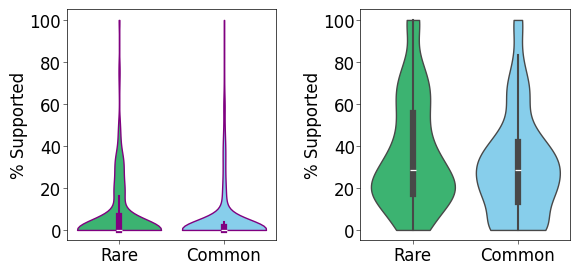

In [52]:
plt.rcParams.update({'font.size': 12})
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(6.5, 3), gridspec_kw={'wspace':0.4})
sns.violinplot(boxplot_df[boxplot_df.variable.isin(['RareBefore', 'CommonBefore'])], x='variable', y='value', hue='variable', cut=0, 
               palette=['mediumseagreen', 'skyblue'], saturation=1, ax=ax1, edgecolor='purple')
sns.violinplot(boxplot_df[boxplot_df.variable.isin(['RareAfter', 'CommonAfter'])], x='variable', y='value', hue='variable', cut=0, 
               palette=['mediumseagreen', 'skyblue'], saturation=1, ax=ax2)
for ax in [ax1, ax2]:
    ax.set_ylabel('% Supported')
    ax.set_xticks([0,1], ['Rare', 'Common'])
    ax.set_xlabel('')
plt.savefig(os.path.join(figdir, 'overlap_after_violins.jpg'), dpi=400, bbox_inches='tight')

In [50]:
(top_split_results['overlap+RareCommonZ'] / (top_split_results['Overlap']+1)).describe()

count    320.000000
mean       9.515908
std       12.408934
min        0.000000
25%        3.000000
50%        6.000000
75%       11.000000
max      102.000000
dtype: float64

In [51]:
top_split_results

,Overlap,RareOnly,CommonOnly,TraitR,TraitC,EFO,Rare_Zr,Rare_Zc,Rare_Zrc,Common_Zr,Common_Zc,Common_Zrc,trait_pair,overlap+rare,Total,overlap+RareZ,overlap+RareCommonZ,PercentSupported,PercentIncrease
71,25,51,571,33230300.0_EFO_0005763,GCST90310296_EFO_0005763,EFO_0005763,51,11,12,139,571,152,33230300.0_EFO_0005763_GCST90310296_EFO_0005763,76,647,37,189,0.292117,0.253478
89,17,36,3,34226706.0_EFO_0007986,GCST90025970_EFO_0007986,EFO_0007986,36,17,17,2,3,2,34226706.0_EFO_0007986_GCST90025970_EFO_0007986,53,56,34,36,0.642857,0.339286
73,17,32,441,33230300.0_EFO_0006336,GCST90449057_EFO_0006336,EFO_0006336,32,6,8,117,441,136,33230300.0_EFO_0006336_GCST90449057_EFO_0006336,49,490,25,161,0.328571,0.293878
72,16,41,447,33230300.0_EFO_0006335,GCST90449056_EFO_0006335,EFO_0006335,41,12,12,122,447,129,33230300.0_EFO_0006335_GCST90449056_EFO_0006335,57,504,28,157,0.311508,0.279762
316,14,224,9,36809768.0_EFO_0020946,GCST90269691_EFO_0020946,EFO_0020946,224,91,100,6,9,6,36809768.0_EFO_0020946_GCST90269691_EFO_0020946,238,247,114,120,0.485830,0.429150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,0,3,4,34375979.0_HP_0012115,GCST90276149_HP_0012115,HP_0012115,3,1,2,0,4,0,34375979.0_HP_0012115_GCST90276149_HP_0012115,3,7,2,2,0.285714,0.285714
20,0,3,3,28263315.0_EFO_0021039,GCST90199722_EFO_0021039,EFO_0021039,3,2,2,3,3,3,28263315.0_EFO_0021039_GCST90199722_EFO_0021039,3,6,2,5,0.833333,0.833333
34,0,3,3,29263008.0_EFO_0006792,GCST90001390_EFO_0006792,EFO_0006792,3,2,2,0,3,0,29263008.0_EFO_0006792_GCST90001390_EFO_0006792,3,6,2,2,0.333333,0.333333
214,0,3,3,34375979.0_EFO_1000860,GCST90134619_EFO_1000860,EFO_1000860,3,0,0,0,3,0,34375979.0_EFO_1000860_GCST90134619_EFO_1000860,3,6,0,0,0.000000,0.000000


## NetColoc Spectrum

In [27]:
df.loc[:, ('logp_nps', 'Mean_NPS', 'logp_size', 'log2SizeOE')].corr()

,logp_nps,Mean_NPS,logp_size,log2SizeOE
logp_nps,1.000000,0.724092,0.809532,0.735754
Mean_NPS,0.724092,1.000000,0.874628,0.905549
logp_size,0.809532,0.874628,1.000000,0.859729
log2SizeOE,0.735754,0.905549,0.859729,1.000000


In [28]:
over_df = pd.read_csv('/cellar/users/snwright/Data/RareCommon/outputs/overlap/rvc_overlap_results_Jan_2025_v2.txt', sep='\t',
                     header=None, names=['trait_pair', 'param_set', 'n_common', 'n_rare', 'n_overlap', 'background', 'pval'])

over_df['EFO'] = over_df.trait_pair.apply(lambda x: map_trait_code(x))
over_df['StudyC'] = over_df.trait_pair.apply(lambda x: next((match.group() for match in re.finditer(r'GCST\d+', x)), None))
over_df['StudyR'] = over_df.trait_pair.apply(lambda x: x.split('_')[0])
over_df['Expected'] = over_df.n_rare * over_df.n_common / 9000
over_df['logp'] = -1 * np.log10(over_df['pval'] + 1e-250)
over_df.head()
over_df = over_df[over_df.trait_pair.isin(pairs)]

In [29]:
plot_df = df.sort_values('log2SizeOE', ascending=False).drop_duplicates(subset=['EFO'], keep='first').dropna()


In [30]:
plot_df = plot_df.merge(over_df.loc[:, ['trait_pair', 'n_overlap','Expected', 'n_common', 'n_rare','logp']], on='trait_pair', how='left')
#df = df.merge(over_df.loc[:, ['trait_pair', 'n_overlap','Expected', 'n_common', 'n_rare','logp']], on='trait_pair', how='left')

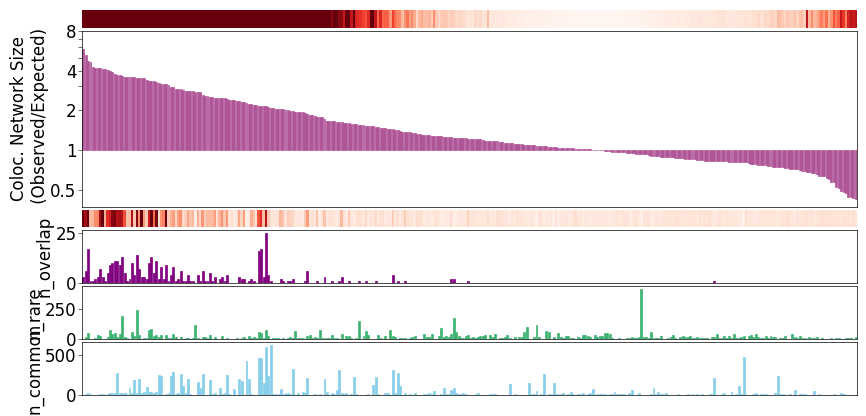

In [31]:
plt.rcParams.update({'font.size': 12})
_, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(6, 1, figsize=(10, 5), sharey=False, sharex=False, 
                                       gridspec_kw={'height_ratios': [1,10, 1, 3,3,3], 'hspace':0.05})
#plot_df = plot_df.merge(over_df.loc[:, ['trait_pair', 'n_overlap','Expected', 'n_common', 'n_rare','logp']], on='trait_pair', how='left').sort_values('log2SizeOE', ascending=False)
order= plot_df.EFO.values
keep_trait_pairs = plot_df.trait_pair.values

sns.heatmap(np.array(plot_df.set_index('EFO').loc[order]['logp_size']).reshape(-1, 1).T, ax=ax1, cbar=False, 
            cmap='Reds', yticklabels=False, xticklabels=False, vmax=25, vmin=0)

sns.barplot(plot_df, x='EFO',
           y='log2SizeOE', color='#AE5497', edgecolor='#AE5497', alpha=1, saturation=1, ax=ax2)

sns.heatmap(np.array(plot_df.set_index('EFO').loc[order]['logp']).reshape(-1, 1).T, ax=ax3, cbar=False, 
            cmap='Reds', yticklabels=False, xticklabels=False, vmax=25, vmin=0)

sns.barplot(plot_df, x='EFO',
           y='n_overlap', color='purple', edgecolor='purple', alpha=1, saturation=1, ax=ax4)

sns.barplot(plot_df, x='EFO',
           y='n_rare', color='mediumseagreen', edgecolor='mediumseagreen', alpha=1, saturation=1, ax=ax5)

sns.barplot(plot_df, x='EFO',
           y='n_common', color='skyblue', edgecolor='skyblue', alpha=1, saturation=1, ax=ax6)

_ = ax2.set_yticks([-1, 0, 1,1.6, 2,2.32,2.58,2.8, 3], labels=[0.5, 1, 2,'', 4,'','','', 8])
ax2.set_ylabel('Coloc. Network Size\n (Observed/Expected)')

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    _ = ax.set_xticks([])
    _ = ax.set_xlabel('')
#plt.savefig(os.path.join(figdir, 'netcoloc_spectrum.svg'), dpi=400, bbox_inches='tight')

### Trait Type

In [85]:
trait_df = pd.read_csv('/cellar/users/snwright/Data/Transfer/RVC/TraitClassification.tsv', sep='\t')
trait_df['EFO'] = trait_df.EFO.apply(lambda x: x.replace(':', '_'))
trait_df.head()


,EFO,Sub-Category,Category
0,EFO_0000319,Cardiovascular,Cardiovascular
1,EFO_0000537,Cardiovascular,Cardiovascular
2,EFO_0000612,Cardiovascular,Cardiovascular
3,EFO_0009289,Cardiovascular,Cardiovascular
4,EFO_0004269,Cardiovascular,Cardiovascular


In [86]:
plot_df = plot_df.merge(trait_df.loc[:, ('EFO', 'Category')], on='EFO', how='left')

In [130]:
plot_df = plot_df.assign(dir_logp = plot_df.apply(lambda x: -1 * x.logp_size if x.log2SizeOE <0 else x.logp_size, axis=1))

In [128]:
plot_df = plot_df.assign()

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,...,log2SizeOE,logp_nps,logp_size,trait_pair,n_overlap,Expected,n_common,n_rare,logp,Category
0,23263489.0_EFO_0009961,GCST008110_EFO_0009961,pcnet2_0,neglog10,sum,0.573017,0.015954,0.0,1045,178.560,...,2.549022,250.0,250.0,23263489.0_EFO_0009961_GCST008110_EFO_0009961,3,0.001333,3,4,250.000000,Protein Measurement
1,34662886.0_EFO_0009253,GCST90025971_EFO_0009253,pcnet2_0,neglog10,sum,0.663491,0.013224,0.0,859,163.101,...,2.396893,250.0,250.0,34662886.0_EFO_0009253_GCST90025971_EFO_0009253,6,0.012444,8,14,21.965819,Hematological Measurement
2,34226706.0_EFO_0007986,GCST90025970_EFO_0007986,pcnet2_0,neglog10,sum,0.678508,0.014398,0.0,910,193.425,...,2.234092,250.0,250.0,34226706.0_EFO_0007986_GCST90025970_EFO_0007986,17,0.117778,20,53,45.521214,Hematological Measurement
3,31367044.0_EFO_0005001,GCST90302070_EFO_0005001,pcnet2_0,neglog10,sum,0.579003,-0.008524,0.0,891,191.747,...,2.216221,250.0,250.0,31367044.0_EFO_0005001_GCST90302070_EFO_0005001,1,0.002333,7,3,6.501740,Other
4,34375979.0_EFO_0006925,GCST90025993_EFO_0006925,pcnet2_0,neglog10,sum,0.702662,0.018079,0.0,727,170.767,...,2.089926,250.0,250.0,34375979.0_EFO_0006925_GCST90025993_EFO_0006925,1,0.002222,4,5,6.522944,Protein Measurement


In [32]:
category_map = {'Lipid Measurement':'Lipid Meas.', 'Protein Measurement': 'Protein Meas.',
       'Hematological Measurement': 'Hematological Meas.', 'Body Measurement': 'Body Meas.', 
                'Cardiovascular': 'Cardiovascular',
       'Gastro':'GastroIntestinal',  'NPD':'Neuro/Psych/Behav.', 'Metabolite Measurement': 'Metabolite Meas.', 
        'Respiratory':'Respiratory', 'Eye/Ear/Skin':'Eye/Ear/Skin', 'Immune/Infection':'Immune/Infection', 
        'Endocrine':'Endocrine', 'Neoplasm':'Neoplasm',
       'Skeletal/Connective':'Skeletal/Connective','Other':'Other'}

/tmp/ipykernel_2931253/2268606288.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ =ax2.set_xticklabels([category_map[x.get_text()] for x in ax2.get_xticklabels()])


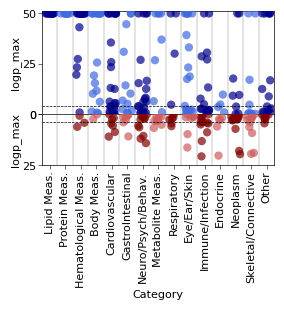

In [268]:
man_df = plot_df.copy()

man_df['logp_max'] = man_df['dir_logp'].apply(lambda x: min(x, 50))
order = ['Lipid Measurement', 'Protein Measurement',
       'Hematological Measurement', 'Body Measurement', 'Cardiovascular',
       'Gastro', 'NPD', 'Metabolite Measurement', 'Respiratory', 
       'Eye/Ear/Skin', 'Immune/Infection', 'Endocrine', 'Neoplasm',
       'Skeletal/Connective','Other']
_, [ax1, ax2] = plt.subplots(ncols=1, nrows=2, figsize=(3, 2), sharex=True, gridspec_kw={'hspace':0, 'height_ratios':[5,2.5]})
sns.stripplot(man_df[man_df.log2SizeOE>0], x='Category', y='logp_max', hue='Category', jitter=0.3, s=6,
              palette=['darkblue', 'royalblue']*7+['darkblue'], alpha=0.7, order=order, hue_order=order, ax=ax1)
sns.stripplot(man_df[man_df.log2SizeOE<0], x='Category', y='logp_max', hue='Category', jitter=0.3, s=6,
              palette=['maroon', 'indianred']*7+['maroon'], alpha=0.7, order=order, hue_order=order, ax=ax2)
#sns.boxplot(man_df, x='Category', y='dir_logp', fliersize=0, order=order)
ax2.tick_params(axis='x', rotation=90)
#ax1.set_ylim(0,20)
ax1.hlines(y=3.8, xmin=-0.5, xmax=14.5, color='black',linewidth=0.5, linestyle='--', zorder=100)
ax2.hlines(y=-3.8, xmin=-0.5, xmax=14.5, color='black',linewidth=0.5, linestyle='--', zorder=100)
ax1.tick_params(axis='x', length=0)
ax1.set_xlim(-0.5, 14.5)
ax1.set_ylim(0, 51)
ax2.set_ylim(-25, 0)
ax1.vlines(x=[i+0.5 for i in range(14)], ymin=255, ymax=0, linewidth=0.3, color='grey')
ax2.vlines(x=[i+0.5 for i in range(14)], ymin=-25, ymax=0, linewidth=0.3, color='grey')
_ = ax1.set_yticks([0, 25, 50])
_ = ax2.set_yticks([0, -25], [0, 25])
_ =ax2.set_xticklabels([category_map[x.get_text()] for x in ax2.get_xticklabels()])
plt.savefig(os.path.join(figdir, 'TraitType_Manhattan.svg'), bbox_inches='tight')



### Network Features

In [76]:
net_df = pd.read_csv('/cellar/users/snwright/Data/RareCommon/outputs/Features/initial_net_features.tsv', sep='\t')

In [34]:
net_df.head()

,trait,varset,subnetwork_density,n_components,average_degree,subnetwork_average_degree,clustering,subnetwork_clustering,assortativity,average_path,subnetwork_assortativity,SetSize,Modularity
0,34375979.0_EFO_0009322_GCST007289_EFO_0009322,rare,0.0,4,362.250000,0.0,0.245490,0.0,-0.000188,2.333333,NaN,4.0,-6.005819e-08
1,34375979.0_EFO_0009322_GCST007289_EFO_0009322,common,0.0,7,166.142857,0.0,0.279579,0.0,-0.000151,2.571429,NaN,7.0,-3.362651e-08
2,34375979.0_EFO_0009322_GCST007289_EFO_0009322,overlap,0.0,0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,NaN,0.0,0.000000e+00
3,34375979.0_EFO_0009322_GCST007289_EFO_0009322,rare_common,0.0,11,237.454545,0.0,0.269090,0.0,-0.000339,2.454545,0.0,11.0,-1.835635e-07
4,34375979.0_EFO_0007997_GCST004608_EFO_0007997,rare,0.0,11,285.000000,0.0,0.257782,0.0,-0.000407,2.672727,NaN,11.0,-3.175640e-07


In [115]:
def compare_to_annot(net_df, col, rvc_df):
    use_df = net_df.pivot(index=['trait'], columns='varset', values=col).reset_index()
    use_df.columns.name=None
    use_df.head()
    use_df = use_df.assign(min_col=use_df.apply(lambda x: min(x.rare, x.common), axis=1),
                            max_col=use_df.apply(lambda x: max(x.rare, x.common), axis=1),
                            col_diff=use_df.apply(lambda x: abs(x.rare - x.common), axis=1))
                           
    try:
        use_df = use_df.assign(col_ratio=use_df.apply(lambda x: max(x.rare/x.common, x.common/x.rare), axis=1))                  
    except ZeroDivisionError:
        pass    
    df_out = use_df.merge(rvc_df.loc[:, ('log2SizeOE', 'logp_size', 'trait_pair')], left_on='trait', right_on='trait_pair',how='left')
    sns.heatmap(df_out.corr(numeric_only=True, method='spearman'), cmap='RdBu', center=0)

#### Degree

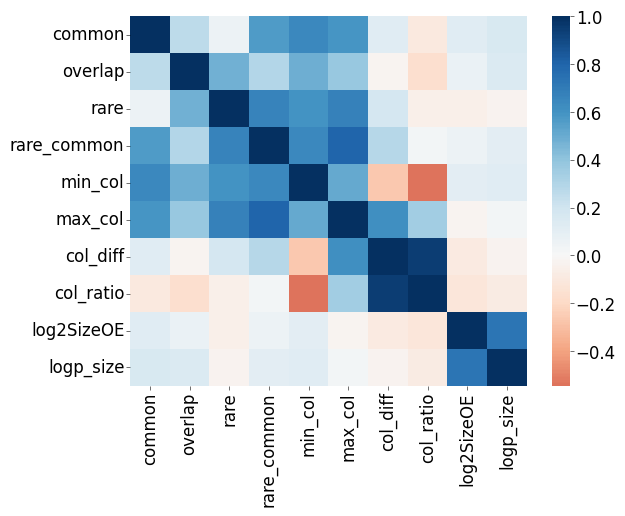

In [78]:
net_df.loc[(net_df.varset=='overlap') & (net_df.average_degree==0), ('average_degree')] = np.nan
compare_to_annot('average_degree', plot_df)

#### Clustering

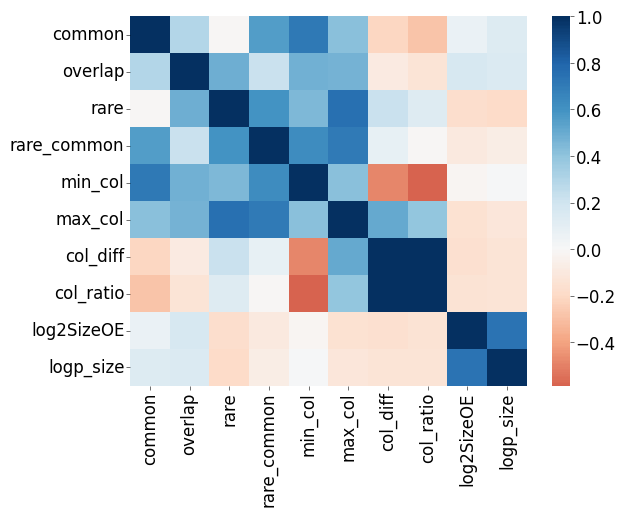

In [80]:
net_df.loc[(net_df.varset=='overlap') & (net_df.clustering==0), ('clustering')] = np.nan
compare_to_annot('clustering', plot_df)

#### Average Path

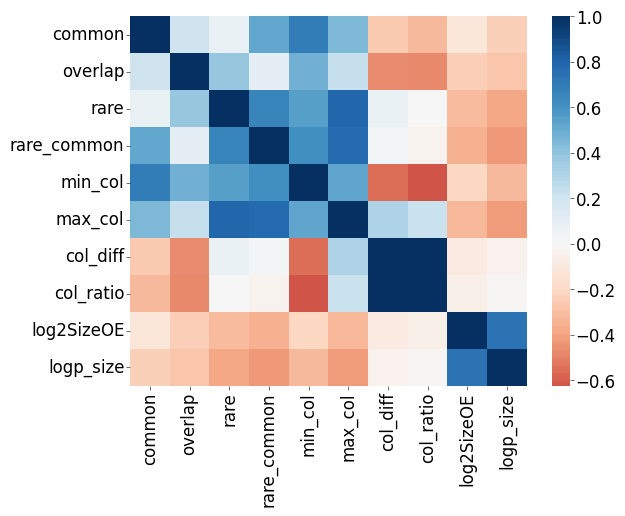

In [82]:
net_df.loc[(net_df.varset=='overlap') & (net_df.average_path==0), ('average_path')] = np.nan
compare_to_annot('average_path', plot_df)

#### Modularity


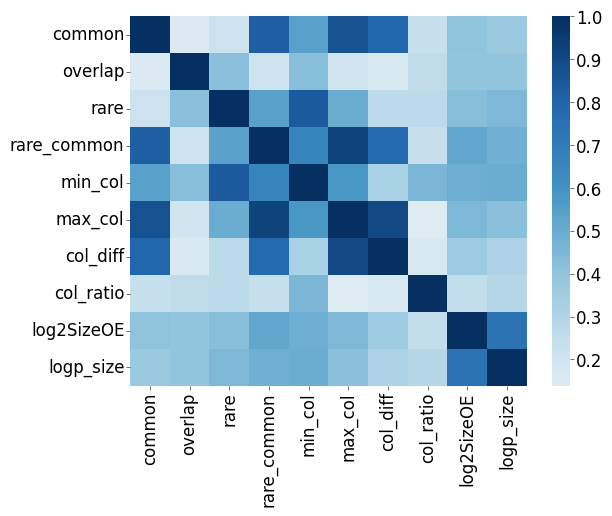

In [83]:
net_df.loc[(net_df.varset=='overlap') & (net_df.Modularity==0), ('Modularity')] = np.nan
compare_to_annot('Modularity', plot_df)

#### Assortativity

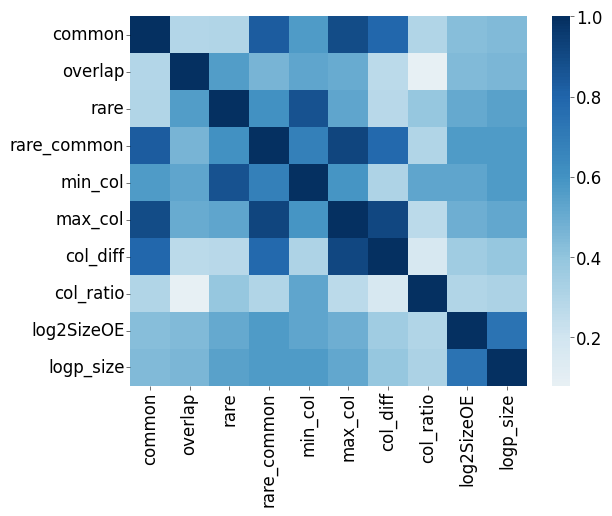

In [86]:
net_df.loc[(net_df.varset=='overlap') & (net_df.assortativity==0), ('assortativity')] = np.nan
compare_to_annot('assortativity', plot_df)

#### Set Size

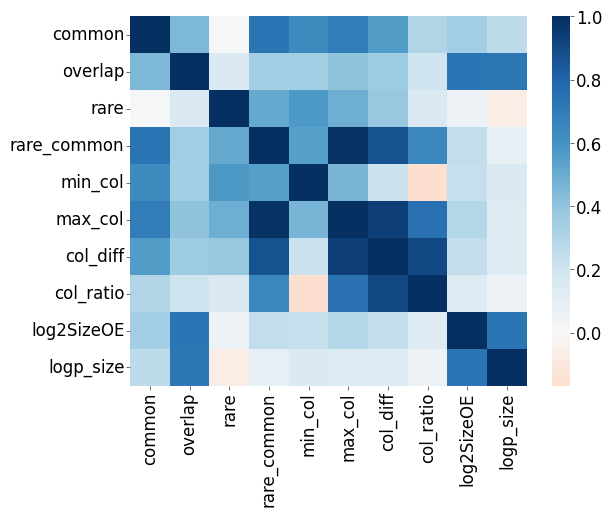

In [87]:
compare_to_annot('SetSize', plot_df)

### Biological Features

In [97]:
bio_df = pd.read_csv('/cellar/users/snwright/Data/RareCommon/outputs/Features/initial_bio_features.tsv', sep='\t')

In [98]:
bio_df.head()

,trait,CDS_Length,CitationCount,GeneSize,LOEUF,Mean_mRNA,OMIM_count,PhyloP_mean,n_Expressed,n_drugs,varset
0,20549515.0_EFO_0000384_GCST90446792_EFO_0000384,1542.0,48.0,39489.0,1.61260,2.734871,0.666667,0.545181,23.555556,3.777778,rare
1,20549515.0_EFO_0000685_GCST90018910_EFO_0000685,1639.5,54.0,31141.5,1.17520,1.850430,0.666667,0.649363,18.666667,2.000000,rare
2,20549515.0_MONDO_0005147_GCST90018925_MONDO_00...,2986.5,302.0,54406.5,5.16725,14.996119,1.500000,0.816136,49.500000,25.500000,rare
3,20691247.0_EFO_0004825_GCST001531_EFO_0004825,1344.0,47.0,147909.0,2.73210,10.635311,0.619048,0.762211,38.142857,2.809524,rare
4,20876667.0_EFO_0000765_GCST001060_EFO_0000765,484.0,124.5,7500.0,1.24340,8.485712,1.000000,0.538368,32.833333,16.333333,rare


In [ ]:
def compare_to_annot(bio_df, col, rvc_df):

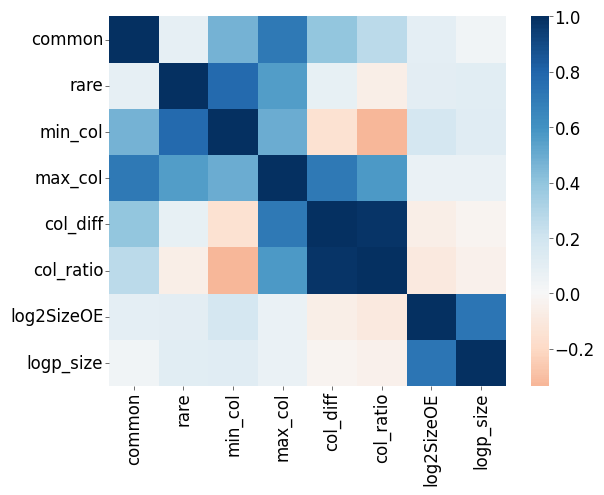

In [99]:
compare_to_annot(bio_df, 'CDS_Length', plot_df)

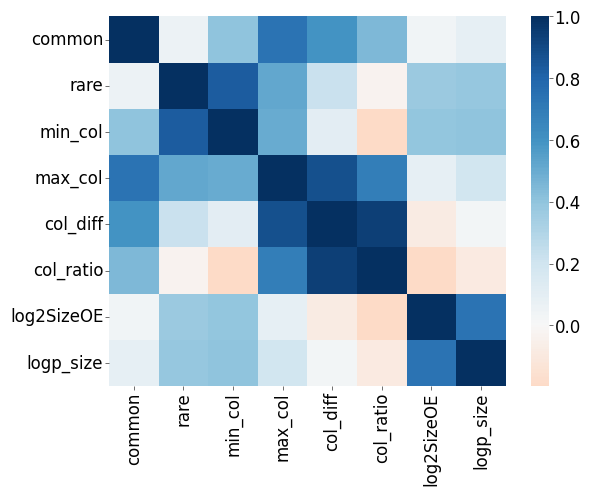

In [100]:
compare_to_annot(bio_df, 'CitationCount', plot_df)

In [101]:
bio_df.columns

Index(['trait', 'CDS_Length', 'CitationCount', 'GeneSize', 'LOEUF',
       'Mean_mRNA', 'OMIM_count', 'PhyloP_mean', 'n_Expressed', 'n_drugs',
       'varset'],
      dtype='object')

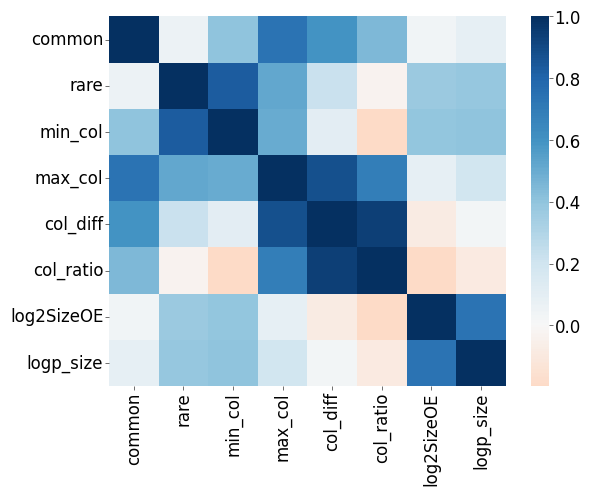

In [102]:
compare_to_annot(bio_df, 'CitationCount', plot_df)

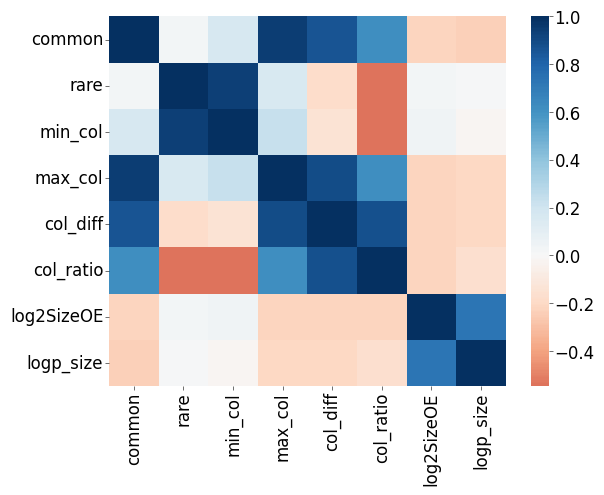

In [103]:
compare_to_annot(bio_df, 'GeneSize', plot_df)

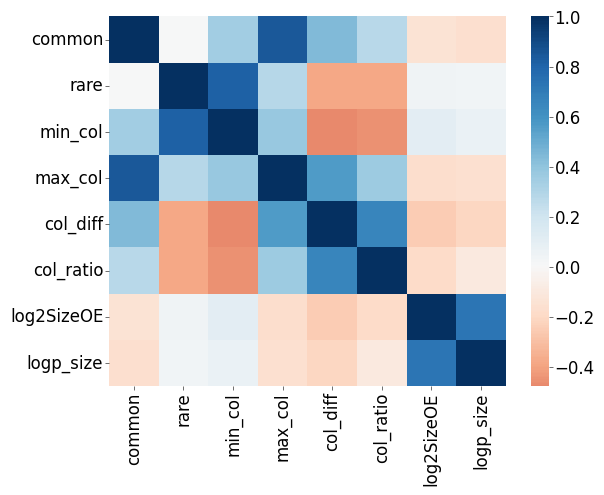

In [104]:
compare_to_annot(bio_df, 'LOEUF', plot_df)

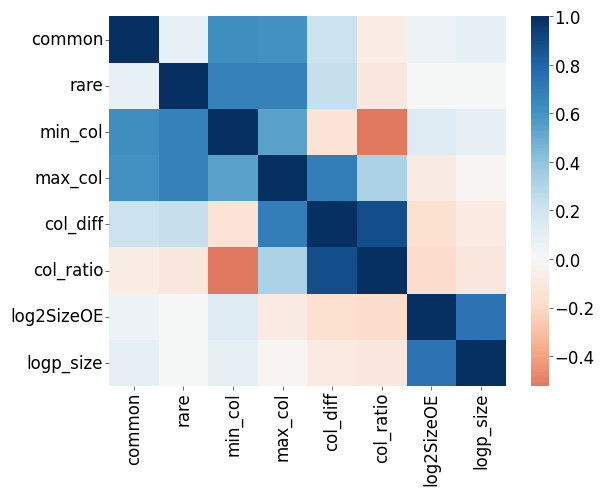

In [105]:
compare_to_annot(bio_df, 'Mean_mRNA', plot_df)

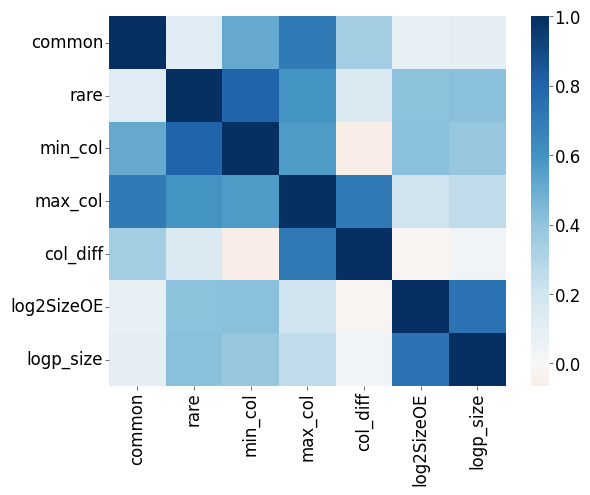

In [116]:
compare_to_annot(bio_df, 'OMIM_count', plot_df)

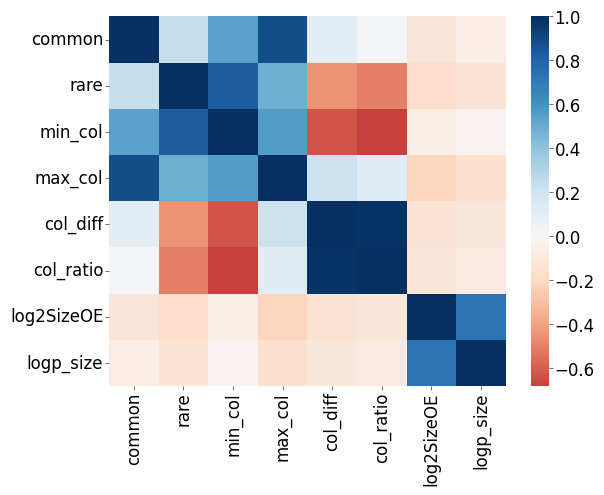

In [117]:
compare_to_annot(bio_df, 'PhyloP_mean', plot_df)

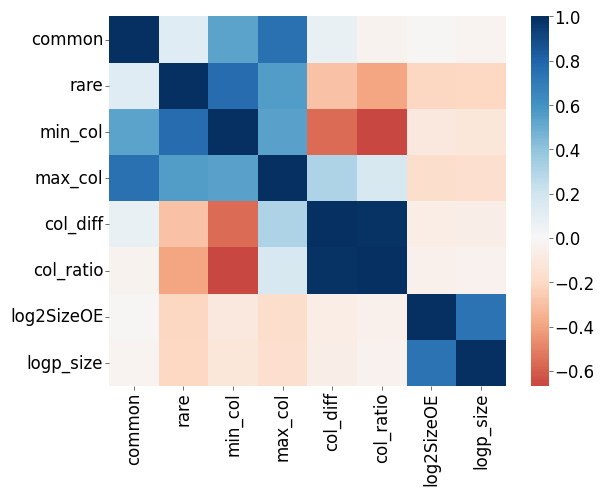

In [118]:
compare_to_annot(bio_df, 'n_Expressed', plot_df)

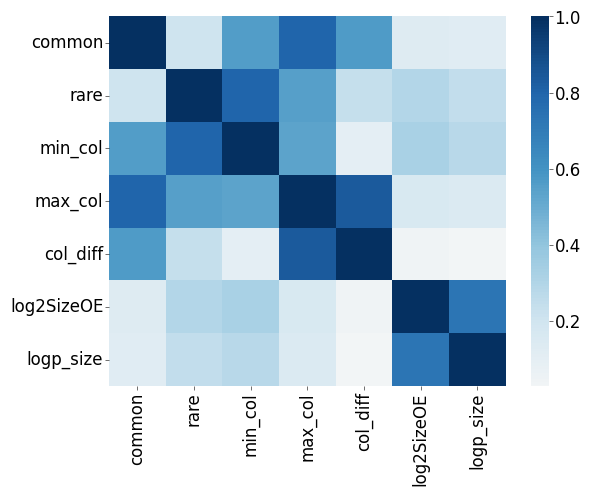

In [119]:
compare_to_annot(bio_df, 'n_drugs', plot_df)

# Development

In [256]:
ax2.get_xticklabels()

[Text(0, 0, 'Lipid Measurement'),
 Text(1, 0, 'Protein Measurement'),
 Text(2, 0, 'Hematological Measurement'),
 Text(3, 0, 'Body Measurement'),
 Text(4, 0, 'Cardiovascular'),
 Text(5, 0, 'Gastro'),
 Text(6, 0, 'NPD'),
 Text(7, 0, 'Metabolite Measurement'),
 Text(8, 0, 'Respiratory'),
 Text(9, 0, 'Eye/Ear/Skin'),
 Text(10, 0, 'Immune/Infection'),
 Text(11, 0, 'Endocrine'),
 Text(12, 0, 'Neoplasm'),
 Text(13, 0, 'Skeletal/Connective'),
 Text(14, 0, 'Other')]

In [206]:
man_df['sig'] = man_df.logp_size > 3.8
man_df['pos'] = man_df.log2SizeOE > 0

In [207]:
not_sig = man_df[man_df.sig==False].groupby('Category').trait_pair.count()
sig_pos = man_df[(man_df.sig==True) & (man_df.pos==True)].groupby('Category').trait_pair.count()
sig_neg = man_df[(man_df.sig==True) & (man_df.pos==False)].groupby('Category').trait_pair.count()

In [208]:
cat_counts = pd.DataFrame({'SigNeg': sig_neg, 'NotSig': not_sig, 'SigPos': sig_pos, }).fillna(0)
cat_counts.index.name=None

In [225]:
(cat_counts.SigPos/cat_counts.sum(axis=1)).sort_values(ascending=False).index.values

array(['Lipid Measurement', 'Protein Measurement',
       'Hematological Measurement', 'Body Measurement', 'Cardiovascular',
       'Gastro', 'NPD', 'Metabolite Measurement', 'Respiratory', 'Other',
       'Eye/Ear/Skin', 'Immune/Infection', 'Endocrine', 'Neoplasm',
       'Skeletal/Connective'], dtype=object)

In [219]:
order = (cat_counts.SigPos/cat_counts.sum()).sort_values('SigPos', ascending=False).index.values

TypeError: Series.sort_values() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

In [216]:
order

array(['Hematological Measurement', 'Cardiovascular', 'Lipid Measurement',
       'Body Measurement', 'NPD', 'Eye/Ear/Skin', 'Protein Measurement',
       'Other', 'Gastro', 'Immune/Infection', 'Metabolite Measurement',
       'Neoplasm', 'Respiratory', 'Skeletal/Connective', 'Endocrine'],
      dtype=object)

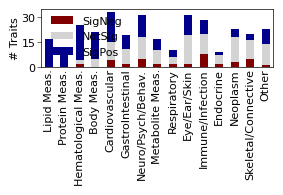

In [269]:
_ = plt.figure(figsize=(3, 0.75))
cat_counts.loc[order].plot(kind='bar', stacked=True, color=['maroon', 'lightgrey', 'darkblue'], ax=plt.gca())
plt.gca().tick_params(axis='x', length=0)
plt.ylabel('# Traits')
_ = plt.yticks([0,15,30])
_ = plt.xticks(plt.xticks()[0], [category_map[x.get_text()] for x in plt.xticks()[1]])
plt.savefig(os.path.join(figdir, 'Trait_CategoryBar.svg'), bbox_inches='tight')

In [186]:
man_df.groupby(['Category', 'pos']).sig.value_counts().reset_index()

,Category,pos,sig,count
0,Body Measurement,False,True,8
1,Body Measurement,False,False,5
2,Body Measurement,True,True,8
3,Cardiovascular,False,True,15
4,Cardiovascular,False,False,11
5,Cardiovascular,True,True,7
6,Endocrine,False,False,5
7,Endocrine,False,True,4
8,Eye/Ear/Skin,False,False,17
9,Eye/Ear/Skin,False,True,10


In [183]:
pos = (man_df[man_df.log2SizeOE>0].groupby('Category').logp_size > 3.8).value_counts().to_dict()
neg = (man_df[man_df.log2SizeOE<0].groupby('Category').logp_size > 3.8).value_counts().to_dict()
bar_df = pd.DataFrame({'pos': pos, 'neg':neg})
bar_df

TypeError: '>' not supported between instances of 'SeriesGroupBy' and 'float'

In [79]:
plot_df.to_csv(os.path.join(datadir, 'outputs/netcoloc', 'prelim_coloc_results.tsv'), sep='\t', index=False)


In [99]:
221/327

0.6758409785932722

In [63]:
plot_df[plot_df.P_size < 0.05/327]

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,...,StudyR,log2SizeOE,logp_nps,logp_size,trait_pair,n_overlap,Expected,n_common,n_rare,logp
0,23263489.0_EFO_0009961,GCST008110_EFO_0009961,pcnet2_0,neglog10,sum,0.573017,0.015954,0.000000e+00,1045,178.560,...,23263489.0,2.549022,250.000000,250.000000,23263489.0_EFO_0009961_GCST008110_EFO_0009961,3,0.001333,3,4,250.000000
1,34662886.0_EFO_0009253,GCST90025971_EFO_0009253,pcnet2_0,neglog10,sum,0.663491,0.013224,0.000000e+00,859,163.101,...,34662886.0,2.396893,250.000000,250.000000,34662886.0_EFO_0009253_GCST90025971_EFO_0009253,6,0.012444,8,14,21.965819
2,34226706.0_EFO_0007986,GCST90025970_EFO_0007986,pcnet2_0,neglog10,sum,0.678508,0.014398,0.000000e+00,910,193.425,...,34226706.0,2.234092,250.000000,250.000000,34226706.0_EFO_0007986_GCST90025970_EFO_0007986,17,0.117778,20,53,45.521214
3,31367044.0_EFO_0005001,GCST90302070_EFO_0005001,pcnet2_0,neglog10,sum,0.579003,-0.008524,0.000000e+00,891,191.747,...,31367044.0,2.216221,250.000000,250.000000,31367044.0_EFO_0005001_GCST90302070_EFO_0005001,1,0.002333,7,3,6.501740
4,34375979.0_EFO_0006925,GCST90025993_EFO_0006925,pcnet2_0,neglog10,sum,0.702662,0.018079,0.000000e+00,727,170.767,...,34375979.0,2.089926,250.000000,250.000000,34375979.0_EFO_0006925_GCST90025993_EFO_0006925,1,0.002222,4,5,6.522944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,36297015.0_EFO_0004330,GCST001032_EFO_0004330,pcnet2_0,neglog10,sum,-0.108710,0.012251,2.121000e-78,68,143.637,...,36297015.0,-1.078821,77.673459,10.608712,36297015.0_EFO_0004330_GCST001032_EFO_0004330,0,0.003889,5,7,2.757223
314,34375979.0_EFO_0000681,GCST008225_EFO_0000681,pcnet2_0,neglog10,sum,-0.178259,0.000676,1.281000e-143,86,192.819,...,34375979.0,-1.164839,142.892451,17.927383,34375979.0_EFO_0000681_GCST008225_EFO_0000681,0,0.002667,3,8,2.920971
315,34375979.0_EFO_0000783,GCST90270216_EFO_0000783,pcnet2_0,neglog10,sum,-0.193437,-0.000077,6.489000e-127,97,220.218,...,34375979.0,-1.182876,126.187822,20.588044,34375979.0_EFO_0000783_GCST90270216_EFO_0000783,0,0.006667,6,10,2.523367
316,34662886.0_EFO_0007772,GCST007616_EFO_0007772,pcnet2_0,neglog10,sum,-0.547906,0.003787,0.000000e+00,90,207.462,...,34662886.0,-1.204850,250.000000,18.888401,34662886.0_EFO_0007772_GCST007616_EFO_0007772,0,0.001667,3,5,3.125026


KeyError: 'n_overlap'

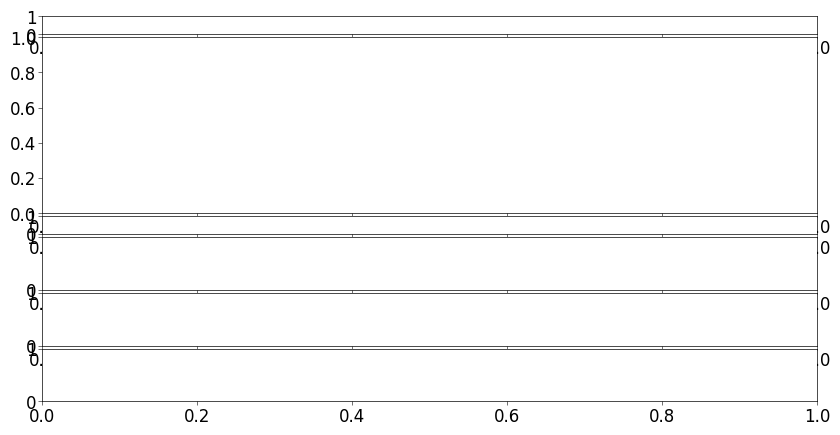

In [64]:
plt.rcParams.update({'font.size': 12})
_, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(6, 1, figsize=(10, 5), sharey=False, sharex=False, 
                                       gridspec_kw={'height_ratios': [1,10, 1, 3,3,3], 'hspace':0.05})
plot_df = df.sort_values('n_overlap', ascending=False).drop_duplicates(subset=['EFO'], keep='first').dropna().sort_values('log2SizeOE', ascending=False)
#plot_df = plot_df.merge(over_df.loc[:, ['trait_pair', 'n_overlap','Expected', 'n_common', 'n_rare','logp']], 
 #                       on='trait_pair', how='left').sort_values('log2SizeOE', ascending=False)
order= plot_df.EFO.values

sns.heatmap(np.array(plot_df.set_index('EFO').loc[order]['logp_size']).reshape(-1, 1).T, ax=ax1, cbar=False, 
            cmap='Reds', yticklabels=False, xticklabels=False, vmax=50, vmin=0)

sns.barplot(plot_df, x='EFO',
           y='log2SizeOE', color='#AE5497', edgecolor='#AE5497', alpha=1, saturation=1, ax=ax2)

sns.heatmap(np.array(plot_df.set_index('EFO').loc[order]['logp']).reshape(-1, 1).T, ax=ax3, cbar=False, 
            cmap='Reds', yticklabels=False, xticklabels=False, vmax=50, vmin=0)

sns.barplot(plot_df, x='EFO',
           y='n_overlap', color='purple', edgecolor='purple', alpha=1, saturation=1, ax=ax4)

sns.barplot(plot_df, x='EFO',
           y='n_rare', color='mediumseagreen', edgecolor='mediumseagreen', alpha=1, saturation=1, ax=ax5)

sns.barplot(plot_df, x='EFO',
           y='n_common', color='skyblue', edgecolor='skyblue', alpha=1, saturation=1, ax=ax6)

_ = ax2.set_yticks([-1, 0, 1,1.6, 2,2.32,2.58,2.8, 3], labels=[0.5, 1, 2,'', 4,'','','', 8])
ax2.set_ylabel('Coloc. Network Size\n (Observed/Expected)')

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    _ = ax.set_xticks([])
    _ = ax.set_xlabel('')
plt.savefig(os.path.join(figdir, 'netcoloc_spectrum.svg'), dpi=400, bbox_inches='tight')

In [74]:
plot_df[(plot_df.logp_size > 3.8) & (plot_df.log2SizeOE < 0)].shape

(38, 23)

In [72]:
plot_df.S

AttributeError: 'DataFrame' object has no attribute 'SizeOE'

In [77]:
plot_df[(plot_df.logp > 3.8)& (plot_df.n_overlap> plot_df.Expected)].shape

(80, 23)

In [76]:
plot_df.head()

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,...,StudyR,log2SizeOE,logp_nps,logp_size,trait_pair,n_overlap,Expected,n_common,n_rare,logp
0,23263489.0_EFO_0009961,GCST008110_EFO_0009961,pcnet2_0,neglog10,sum,0.573017,0.015954,0.0,1045,178.560,...,23263489.0,2.549022,250.0,250.0,23263489.0_EFO_0009961_GCST008110_EFO_0009961,3,0.001333,3,4,250.000000
1,34662886.0_EFO_0009253,GCST90025971_EFO_0009253,pcnet2_0,neglog10,sum,0.663491,0.013224,0.0,859,163.101,...,34662886.0,2.396893,250.0,250.0,34662886.0_EFO_0009253_GCST90025971_EFO_0009253,6,0.012444,8,14,21.965819
2,34226706.0_EFO_0007986,GCST90025970_EFO_0007986,pcnet2_0,neglog10,sum,0.678508,0.014398,0.0,910,193.425,...,34226706.0,2.234092,250.0,250.0,34226706.0_EFO_0007986_GCST90025970_EFO_0007986,17,0.117778,20,53,45.521214
3,31367044.0_EFO_0005001,GCST90302070_EFO_0005001,pcnet2_0,neglog10,sum,0.579003,-0.008524,0.0,891,191.747,...,31367044.0,2.216221,250.0,250.0,31367044.0_EFO_0005001_GCST90302070_EFO_0005001,1,0.002333,7,3,6.501740
4,34375979.0_EFO_0006925,GCST90025993_EFO_0006925,pcnet2_0,neglog10,sum,0.702662,0.018079,0.0,727,170.767,...,34375979.0,2.089926,250.0,250.0,34375979.0_EFO_0006925_GCST90025993_EFO_0006925,1,0.002222,4,5,6.522944


In [559]:
plot_df.loc[:, ('logp_nps', 'Mean_NPS', 'logp_size', 'log2SizeOE', 'logp', 'n_overlap')].corr()

,logp_nps,Mean_NPS,logp_size,log2SizeOE,logp,n_overlap
logp_nps,1.000000,0.851826,0.869853,0.891345,0.276788,0.548174
Mean_NPS,0.851826,1.000000,0.890032,0.903641,0.368436,0.593519
logp_size,0.869853,0.890032,1.000000,0.918878,0.356668,0.656911
log2SizeOE,0.891345,0.903641,0.918878,1.000000,0.332999,0.584626
logp,0.276788,0.368436,0.356668,0.332999,1.000000,0.286151
n_overlap,0.548174,0.593519,0.656911,0.584626,0.286151,1.000000


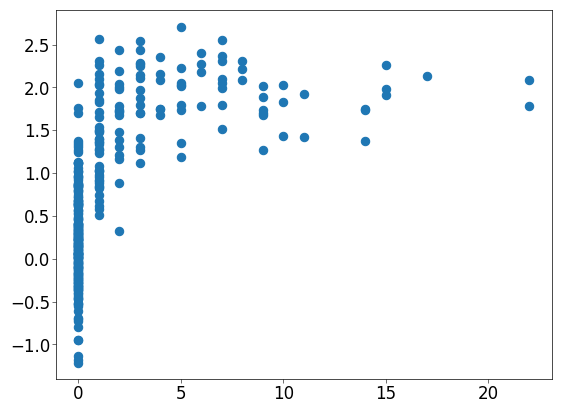

In [562]:
plt.scatter(data=plot_df, x='n_overlap', y='log2SizeOE')

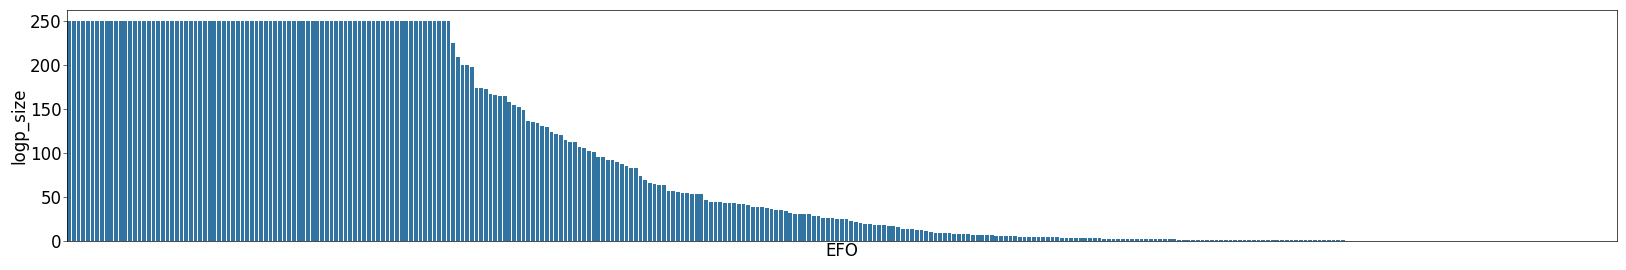

In [481]:
_, [ax1, ax4, ax2, ax3] = plt.subplots(4, 1, figsize=(5, 3), sharey=False, sharex=False, gridspec_kw={'height_ratios': [1,1, 10, 10], 'hspace':0.1})
plot_df = plot_df.sort_values(by='Mean_NPS', ascending=False)
order = plot_df['TraitR'].values
#sns.barplot(data=df, y='log10_P_mean_NPS', x='TraitR', ax=ax1)
sns.heatmap(np.array(plot_df.set_index('TraitR').loc[order]['log10_pval']).reshape(-1, 1).T, ax=ax4, cbar=False, cmap='Reds', yticklabels=False, xticklabels=False, vmax=50, vmin=0)
sns.heatmap(np.array(plot_df.set_index('TraitR').loc[order]['log10_P_mean_NPS']).reshape(-1, 1).T, ax=ax1, cbar=False, cmap='Reds', yticklabels=False, xticklabels=False, vmax=50, vmin=0)
sns.barplot(data=plot_df, y='Mean_NPS', x='TraitR', ax=ax2, color='royalblue', saturation=0.8)
sns.barplot(data=plot_df, x='TraitR', y='oe', ax=ax3, order=order, color='purple', saturation=0.9)
ax3.set_ylim(0, 100)
for ax in [ax1, ax2, ax3]:
    _ = ax.set_xticks([])
    ax.set_xlabel('')
ax2.set_ylabel('Mean NPS', fontsize=8)
ax3.set_ylabel('Gene Overlap\nObserved/Expected', fontsize=8)
plt.savefig(os.path.join(figdir, 'overlap_vs_nps_heatmap_v2.png'), bbox_inches='tight', dpi=500)

## Select most and least consistent repeats. ( with min 4 repeats). 

In [384]:
df['trait_pair'] = df['TraitR'] + '_' + df['TraitC']

In [385]:
trait_counts = df.groupby('EFO').trait_pair.nunique().sort_values(ascending=False)
max_repeat_traits = trait_counts[trait_counts==25].index.values
repeat_df = df[df.EFO.isin(max_repeat_traits)]

In [433]:
common_idx = {t: np.tile([1,2,3,4,5], 13)[i] for i, t in enumerate(repeat_df.sort_values('EFO').TraitC.unique())}
rare_idx = {t: np.tile([1,2,3,4,5], 13)[i] for i, t in enumerate(repeat_df.sort_values('EFO').TraitR.unique())}

In [452]:
classes = {'EFO_0004611': 'Measurement', 'EFO_0004526':'Measurement', 'EFO_0009188':'Measurement', 
          'EFO_0001645':'Disease',
       'EFO_0005091':'Measurement', 'EFO_0004458': 'Measurement', 'EFO_0004339': 'Measurement', 
          'MONDO_0005090': 'Disease',
       'EFO_0006335':'Measurement', 'EFO_0000384':"Disease", 'EFO_0006336': 'Measurement'}

In [453]:
repeat_df = repeat_df.assign(Cidx=repeat_df.TraitC.map(common_idx))
repeat_df = repeat_df.assign(Ridx=repeat_df.TraitR.map(rare_idx))
repeat_df = repeat_df.assign(Class=repeat_df.EFO.map(classes))

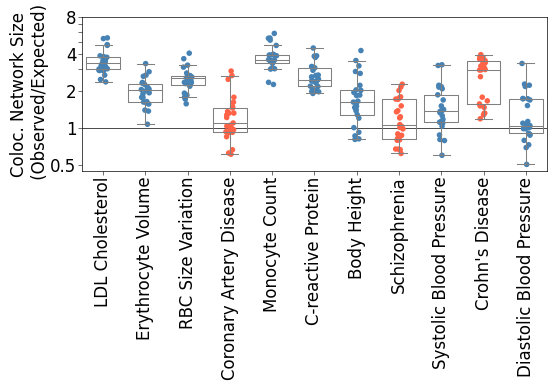

In [582]:
labels = {'EFO_0004611': 'LDL Cholesterol', 'EFO_0004526':'Erythrocyte Volume', 'EFO_0009188':'RBC Size Variation', 
          'EFO_0001645':'Coronary Artery Disease',
       'EFO_0005091':'Monocyte Count', 'EFO_0004458': 'C-reactive Protein', 'EFO_0004339': 'Body Height', 
          'MONDO_0005090': 'Schizophrenia',
       'EFO_0006335':'Systolic Blood Pressure', 'EFO_0000384':"Crohn's Disease", 'EFO_0006336': 'Diastolic Blood Pressure'}
_ = plt.figure(figsize=(6,2))
sns.boxplot(repeat_df, x='EFO', y='log2SizeOE', order=max_repeat_traits, fliersize=0, fill=False, 
            color='grey', linewidth=0.75, zorder=2)
sns.stripplot(repeat_df, x='EFO', y='log2SizeOE', order=max_repeat_traits, hue='Class', alpha=1, s=4, legend=False,
              palette=['tomato', 'steelblue'], edgecolor='black', zorder=1)

_ = plt.xticks([i for i in range(len(labels))], [labels[x] for x in max_repeat_traits], rotation=90)
plt.hlines(y=0, xmin=-0.5, xmax=11, color='black', linewidth=0.5, zorder=0)
plt.xlim((-0.5, 10.5))
plt.ylabel('Coloc. Net. Size\nlog2(O/E)')
plt.xlabel('')
_ = plt.yticks([-1, 0, 1,1.6, 2,2.32,2.58,2.8, 3], labels=[0.5, 1, 2,'', 4,'','','', 8])
plt.ylabel('Coloc. Network Size\n (Observed/Expected)')
plt.savefig(os.path.join(figdir, 'repeat_SizeOE.svg'), dpi=400, bbox_inches='tight')

(-0.5, 10.5)

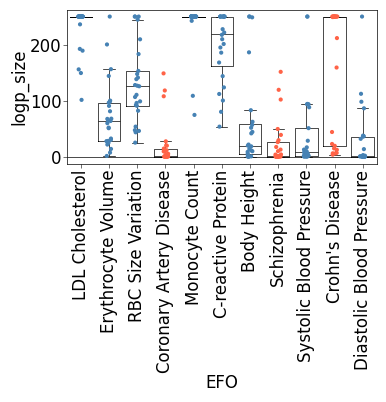

In [459]:
_ = plt.figure(figsize=(4,2))
sns.boxplot(repeat_df, x='EFO', y='logp_size', order=max_repeat_traits, fliersize=0, fill=False, color='black', linewidth=0.5)
sns.stripplot(repeat_df, x='EFO', y='logp_size', order=max_repeat_traits, hue='Class', alpha=1, s=3, legend=False,
              palette=['tomato', 'steelblue'])

_ = plt.xticks([i for i in range(len(labels))], [labels[x] for x in max_repeat_traits], rotation=90)
plt.hlines(y=0, xmin=-0.5, xmax=11, color='black', linewidth=0.5, zorder=0)
plt.xlim((-0.5, 10.5))

(-0.5, 10.5)

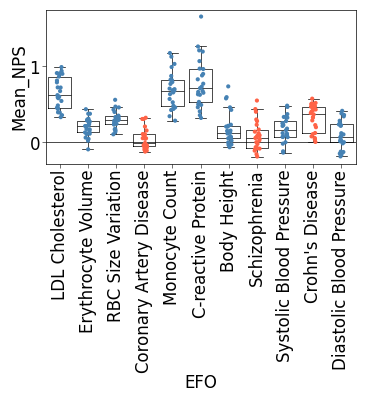

In [460]:
_ = plt.figure(figsize=(4,2))
sns.boxplot(repeat_df, x='EFO', y='Mean_NPS', order=max_repeat_traits, fliersize=0, fill=False, color='black', linewidth=0.5)
sns.stripplot(repeat_df, x='EFO', y='Mean_NPS', order=max_repeat_traits, hue='Class', alpha=1, s=3, legend=False,
              palette=['tomato', 'steelblue'])

_ = plt.xticks([i for i in range(len(labels))], [labels[x] for x in max_repeat_traits], rotation=90)
plt.hlines(y=0, xmin=-0.5, xmax=11, color='black', linewidth=0.5, zorder=0)
plt.xlim((-0.5, 10.5))

(-0.5, 10.5)

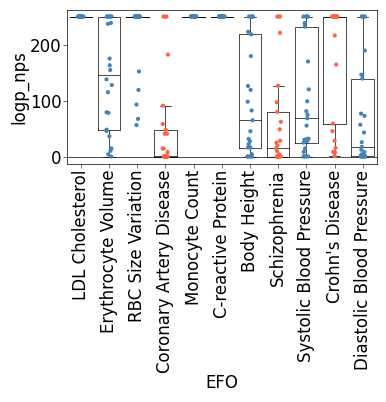

In [461]:
_ = plt.figure(figsize=(4,2))
sns.boxplot(repeat_df, x='EFO', y='logp_nps', order=max_repeat_traits, fliersize=0, fill=False, color='black', linewidth=0.5)
sns.stripplot(repeat_df, x='EFO', y='logp_nps', order=max_repeat_traits, hue='Class', alpha=1, s=3, legend=False,
              palette=['tomato', 'steelblue'])

_ = plt.xticks([i for i in range(len(labels))], [labels[x] for x in max_repeat_traits], rotation=90)
plt.hlines(y=0, xmin=-0.5, xmax=11, color='black', linewidth=0.5, zorder=0)
plt.xlim((-0.5, 10.5))

In [380]:
repeat_df.head()

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,EFO,StudyC,StudyR,log2SizeOE,trait_pair
0,19847924.0_EFO_0001645,GCST005195_EFO_0001645,pcnet2_0,neglog10,sum,-0.006702,-0.009378,3.742000e-01,190,203.982,0.86400,EFO_0001645,GCST005195,19847924.0,-0.102442,19847924.0_EFO_0001645_GCST005195_EFO_0001645
1,19847924.0_EFO_0001645,GCST008370_EFO_0001645,pcnet2_0,neglog10,sum,-0.066996,-0.005094,1.000000e+00,147,173.257,0.98510,EFO_0001645,GCST008370,19847924.0,-0.237097,19847924.0_EFO_0001645_GCST008370_EFO_0001645
2,19847924.0_EFO_0001645,GCST010479_EFO_0001645,pcnet2_0,neglog10,sum,-0.034484,-0.002917,1.000000e+00,176,191.010,0.88950,EFO_0001645,GCST010479,19847924.0,-0.118073,19847924.0_EFO_0001645_GCST010479_EFO_0001645
3,19847924.0_EFO_0001645,GCST90132315_EFO_0001645,pcnet2_0,neglog10,sum,0.055506,0.002766,6.408000e-15,241,189.087,0.00001,EFO_0001645,GCST90132315,19847924.0,0.349983,19847924.0_EFO_0001645_GCST90132315_EFO_0001645
4,19847924.0_EFO_0001645,GCST90449059_EFO_0001645,pcnet2_0,neglog10,sum,-0.041184,-0.005635,1.000000e+00,171,176.668,0.67700,EFO_0001645,GCST90449059,19847924.0,-0.047044,19847924.0_EFO_0001645_GCST90449059_EFO_0001645


In [362]:
size_cv = repeat_df.groupby('EFO').log2SizeOE.std()/repeat_df.groupby('EFO').log2SizeOE.mean()
size_cv

EFO
EFO_0000384      0.473586
EFO_0001645      2.341255
EFO_0004339      0.893126
EFO_0004458      0.251882
EFO_0004526      0.371773
EFO_0004611      0.172175
EFO_0005091      0.178608
EFO_0006335      1.253054
EFO_0006336      2.399123
EFO_0009188      0.249325
MONDO_0005090    2.902939
Name: log2SizeOE, dtype: float64

In [364]:
repeat_df[repeat_df.EFO=='EFO_0001645']

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,EFO,StudyC,StudyR,log2SizeOE,trait_pair
0,19847924.0_EFO_0001645,GCST005195_EFO_0001645,pcnet2_0,neglog10,sum,-0.006702,-0.009378,3.742000e-01,190,203.982,8.640000e-01,EFO_0001645,GCST005195,19847924.0,-0.102442,19847924.0_EFO_0001645_GCST005195_EFO_0001645
1,19847924.0_EFO_0001645,GCST008370_EFO_0001645,pcnet2_0,neglog10,sum,-0.066996,-0.005094,1.000000e+00,147,173.257,9.851000e-01,EFO_0001645,GCST008370,19847924.0,-0.237097,19847924.0_EFO_0001645_GCST008370_EFO_0001645
2,19847924.0_EFO_0001645,GCST010479_EFO_0001645,pcnet2_0,neglog10,sum,-0.034484,-0.002917,1.000000e+00,176,191.010,8.895000e-01,EFO_0001645,GCST010479,19847924.0,-0.118073,19847924.0_EFO_0001645_GCST010479_EFO_0001645
3,19847924.0_EFO_0001645,GCST90132315_EFO_0001645,pcnet2_0,neglog10,sum,0.055506,0.002766,6.408000e-15,241,189.087,1.031000e-05,EFO_0001645,GCST90132315,19847924.0,0.349983,19847924.0_EFO_0001645_GCST90132315_EFO_0001645
4,19847924.0_EFO_0001645,GCST90449059_EFO_0001645,pcnet2_0,neglog10,sum,-0.041184,-0.005635,1.000000e+00,171,176.668,6.770000e-01,EFO_0001645,GCST90449059,19847924.0,-0.047044,19847924.0_EFO_0001645_GCST90449059_EFO_0001645
17,20549515.0_EFO_0001645,GCST005195_EFO_0001645,pcnet2_0,neglog10,sum,-0.043992,0.005861,1.000000e+00,184,175.182,2.268000e-01,EFO_0001645,GCST005195,20549515.0,0.070851,20549515.0_EFO_0001645_GCST005195_EFO_0001645
18,20549515.0_EFO_0001645,GCST008370_EFO_0001645,pcnet2_0,neglog10,sum,-0.072358,0.002916,1.000000e+00,163,148.559,1.117000e-01,EFO_0001645,GCST008370,20549515.0,0.133836,20549515.0_EFO_0001645_GCST008370_EFO_0001645
19,20549515.0_EFO_0001645,GCST010479_EFO_0001645,pcnet2_0,neglog10,sum,-0.066796,0.001517,1.000000e+00,155,163.033,7.546000e-01,EFO_0001645,GCST010479,20549515.0,-0.072896,20549515.0_EFO_0001645_GCST010479_EFO_0001645
20,20549515.0_EFO_0001645,GCST90132315_EFO_0001645,pcnet2_0,neglog10,sum,-0.037362,-0.001878,1.000000e+00,160,161.149,5.407000e-01,EFO_0001645,GCST90132315,20549515.0,-0.010323,20549515.0_EFO_0001645_GCST90132315_EFO_0001645
21,20549515.0_EFO_0001645,GCST90449059_EFO_0001645,pcnet2_0,neglog10,sum,-0.035808,0.002916,1.000000e+00,184,151.339,1.539000e-03,EFO_0001645,GCST90449059,20549515.0,0.281922,20549515.0_EFO_0001645_GCST90449059_EFO_0001645


## Features??

## PCA

In [699]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def compute_pca(df, n_components=2):
    """
    Computes principal components for a given dataframe.
    Assumes columns represent samples.
    
    Parameters:
        df (pd.DataFrame): Dataframe where columns are samples and rows are features.
        n_components (int): Number of principal components to compute.

    Returns:
        pca_df (pd.DataFrame): Transformed dataframe with PCs as rows and samples as columns.
        explained_variance (list): Variance explained by each principal component.
    """
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df.T)  # Transpose so samples are rows
    
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data_scaled)
    
    pca_df = pd.DataFrame(principal_components.T, index=[f'PC{i+1}' for i in range(n_components)], columns=df.columns)
    explained_variance = pca.explained_variance_ratio_
    
    return pca_df, explained_variance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def compute_pca(df, n_components=2):
    """
    Computes principal components for a given dataframe.
    Assumes columns represent samples.
    
    Parameters:
        df (pd.DataFrame): Dataframe where columns are samples and rows are features.
        n_components (int): Number of principal components to compute.

    Returns:
        pca_df (pd.DataFrame): Transformed dataframe with PCs as rows and samples as columns.
        explained_variance (list): Variance explained by each principal component.
    """
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df.T)  # Transpose so samples are rows
    
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data_scaled)
    
    pca_df = pd.DataFrame(principal_components.T, index=[f'PC{i+1}' for i in range(n_components)], columns=df.columns)
    explained_variance = pca.explained_variance_ratio_
    
    return pca_df, explained_variance

def plot_pca(pca_df, explained_variance, pc_x=1, pc_y=2, classifications=None, quantitative_values=None):
    """
    Plots the specified principal components and colors points based on classifications or quantitative values.
    
    Parameters:
        pca_df (pd.DataFrame): Dataframe with PCs as rows and samples as columns.
        explained_variance (list): Variance explained by each PC.
        pc_x (int): The principal component for the x-axis.
        pc_y (int): The principal component for the y-axis.
        classifications (dict, optional): Dictionary mapping sample names to classification labels.
        quantitative_values (dict, optional): Dictionary mapping sample names to numerical values for coloring.
    """
    plt.figure(figsize=(3.5, 3))
    
    x = pca_df.loc[f'PC{pc_x}']
    y = pca_df.loc[f'PC{pc_y}']
    
    if classifications:
        classifications = {k:v for k,v in classifications.items() if k in x.index.values}
        unique_labels = set(classifications.values())
        colors = plt.get_cmap('tab10', len(unique_labels))
        label_to_color = {label: colors(i) for i, label in enumerate(unique_labels)}
        
        for sample, label in classifications.items():
            plt.scatter(x[sample], y[sample], color=label_to_color[label], label=label if label not in plt.gca().get_legend_handles_labels()[1] else "")
    elif quantitative_values:
        values = np.array([quantitative_values.get(sample, np.nan) for sample in pca_df.columns])
        scatter = plt.scatter(x, y, c=values, cmap='viridis', alpha=0.75, s=10)
        plt.colorbar(scatter, label='', fraction=0.1, shrink=0.7, ticks=[0,100,200,250])
    else:
        plt.scatter(x, y, color='blue')
    
    plt.xlabel(f'PC{pc_x} ({explained_variance[pc_x-1]*100:.2f}% var)')
    plt.ylabel(f'PC{pc_y} ({explained_variance[pc_y-1]*100:.2f}% var)')
    plt.title(f'PCA: PC{pc_x} vs PC{pc_y}')
    
    if classifications:
        plt.legend()
    
    plt.grid(True, linestyle='--', alpha=0.6)

In [630]:
len(keep_trait_pairs)

329

In [642]:
pca, var = compute_pca(z_coloc.loc[:, keep_trait_pairs], n_components=10)

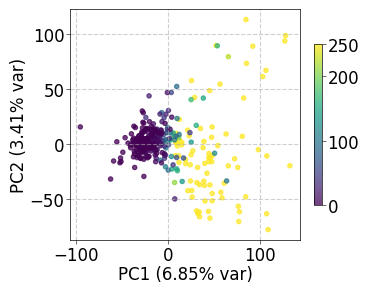

In [701]:

plot_pca(pca, var, pc_x=1, pc_y=2, quantitative_values=df.set_index('trait_pair').logp_size.to_dict())
plt.title('')
plt.savefig(os.path.join(figdir, 'pca_plot.jpg'), dpi=400, bbox_inches='tight')

In [670]:
pca_df = pca.T.sort_values('PC2', ascending=True)
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
36280733.0_EFO_0004530_GCST90025957_EFO_0004530,109.391116,-77.697085,-46.805423,-32.400779,4.124500,-11.571348,-14.492104,5.203641,-9.821815,35.437138
36809768.0_EFO_0004615_GCST90092809_EFO_0004615,77.314052,-70.400877,-5.234775,22.389103,-16.613835,24.274943,-42.509581,5.644441,11.053963,-20.736202
36809768.0_EFO_0008595_GCST90092838_EFO_0008595,45.925319,-67.329619,1.874661,51.025418,-8.806806,14.525011,-27.853599,-3.867377,15.613988,0.835685
36809768.0_EFO_0010733_GCST90092939_EFO_0010733,34.572430,-66.116300,-5.196820,60.953542,-8.301533,1.222164,-6.839449,5.193626,12.322895,26.337056
36809768.0_EFO_0020946_GCST90269736_EFO_0020946,32.793412,-63.413154,21.280804,60.929029,2.490118,14.098863,-15.624559,-3.391592,29.416564,13.247172


In [652]:
efo_groups = { 'EFO:0000408': ['EFO_0007490', 'MONDO_0004979', 'EFO_0000326', 'EFO_0000217', 'EFO_0004208', 'EFO_0000729', 'EFO_0000681', 'EFO_1001513', 'EFO_0004462', 'EFO_0007167', 'EFO_0004253', 'EFO_0004192', 'EFO_0009961', 'MONDO_0018076', 'EFO_0004992', 'EFO_0004314', 'MONDO_0004867', 'EFO_0005761', 'EFO_0005524', 'MONDO_0007254', 'EFO_0000676', 'EFO_0003882', 'MONDO_0005129', 'EFO_0004541', 'EFO_0004266', 'EFO_1000786', 'EFO_0000519', 'EFO_0004617', 'EFO_0005407', 'EFO_0003770', 'EFO_0004283', 'EFO_0004143', 'EFO_0005531', 'EFO_0004696', 'EFO_0009289', 'EFO_0001075', 'MONDO_0004992', 'EFO_0000612', 'EFO_0003948', 'EFO_0004799', 'MONDO_0008903', 'EFO_0010822', 'EFO_0005917', 'MONDO_0004247', 'MONDO_0005178', 'EFO_0003144', 'EFO_0004262', 'EFO_0000284', 'EFO_0005669', 'EFO_0000384', 'EFO_0000266', 'EFO_0007429', 'EFO_0001073', 'EFO_0004286', 'EFO_0001378', 'EFO_0004261', 'EFO_0004587', 'MONDO_0008315', 'EFO_0000756', 'EFO_0000389', 'EFO_0004259', 'EFO_0001365', 'EFO_0004198', 'EFO_0005854', 'EFO_0009959', 'EFO_0004994', 'EFO_0004611', 'EFO_0005240', 'EFO_0006803', 'EFO_0004340', 'EFO_0004213', 'EFO_0000765', 'EFO_0000555', 'EFO_0004269', 'EFO_0001065', 'EFO_0000712', 'EFO_0004695', 'EFO_0000684', 'EFO_0004607', 'EFO_0004307', 'MONDO_0002108', 'MONDO_0005090', 'EFO_1000726', 'MONDO_0021108', 'EFO_0000685', 'EFO_0005952', 'EFO_0000182', 'EFO_1001494', 'EFO_1001178', 'EFO_0005252', 'EFO_0006812', 'MONDO_0018309', 'EFO_0003875', 'EFO_0004228', 'MONDO_0005148', 'EFO_0000275', 'EFO_0005676', 'EFO_0000280', 'EFO_0000537', 'EFO_1001870', 'EFO_0004698', 'MONDO_0016581', 'MONDO_0002974', 'EFO_0000095', 'EFO_0003894', 'HP_0001634', 'EFO_0000403', 'EFO_0003956', 'EFO_0000400', 'EFO_0000274', 'EFO_0007704', 'EFO_0007993', 'EFO_0009130', 'EFO_0004705', 'EFO_1000391', 'EFO_0004238', 'EFO_0006510', 'MONDO_0024647', 'EFO_0004210', 'EFO_0006792', 'EFO_0004593', 'EFO_0009189', 'EFO_0000668', 'MONDO_0005301', 'EFO_0001068', 'MONDO_0001627', 'MONDO_0002009', 'EFO_1000860', 'EFO_1000652', 'EFO_0000699', 'EFO_0008573', 'EFO_0007236', 'EFO_0001060', 'EFO_0000707', 'EFO_0004234', 'MONDO_0005277', 'MONDO_0005147', 'MONDO_0019338', 'EFO_0005938', 'EFO_0003827', 'EFO_0000783', 'EFO_0009270', 'EFO_0003778', 'EFO_0004263', 'EFO_0001645', 'EFO_1000910', 'MONDO_0007915', 'EFO_0000341', 'MONDO_0004907', 'EFO_0009759', 'EFO_0000464', 'EFO_0004682', 'EFO_0003106', 'EFO_0001663', 'EFO_0010226', 'EFO_0002496', 'MONDO_0005041', 'EFO_0000540', 'EFO_1000657', 'EFO_0004570', 'EFO_0004274', 'EFO_0000574', 'EFO_0000538', 'EFO_0000474', 'EFO_1000764', 'EFO_0000677', 'MONDO_0004975', 'EFO_0005207', 'EFO_0009458', 'EFO_0002609', 'MONDO_0004985', 'EFO_0005763', 'EFO_0004251', 'EFO_0003756', 'EFO_1001489', 'EFO_0008406', 'MONDO_0005180', 'EFO_0007191', 'EFO_0005773', 'EFO_0009454', 'EFO_0009322', 'EFO_0007149', 'EFO_0005937', 'EFO_0004197', 'EFO_0006788', 'EFO_0004244', 'MONDO_0001823', 'EFO_0003931', 'EFO_0003819', 'EFO_0001422', 'EFO_0004191', 'MONDO_0017276', 'EFO_0003898', 'EFO_1001864', 'EFO_1000802', 'EFO_0004713', 'MONDO_0018364', 'EFO_1000941', 'EFO_0000198', 'EFO_0004242', 'EFO_0003100', 'EFO_0004193', 'EFO_0004255', 'EFO_0000407', 'EFO_1000049', 'MONDO_0002253', 'EFO_0000319', 'EFO_0004327'],
                        'EFO:0001444' : ['EFO_0010815', 'EFO_0800027', 'EFO_0005089', 'EFO_0010701', 'EFO_0004462', 'EFO_0007985', 'EFO_0004509', 'EFO_0009961', 'EFO_0004305', 'EFO_0020690', 'EFO_0004627', 'EFO_0004314', 'EFO_0005110', 'OBA:0003277', 'EFO_0006335', 'EFO_0004541', 'EFO_0005189', 'EFO_0008595', 'EFO_0004617', 'EFO_0004528', 'EFO_0005091', 'EFO_0007997', 'EFO_0004614', 'EFO_0004696', 'EFO_0009289', 'EFO_0004838', 'EFO_0006941', 'EFO_0004533', 'EFO_0800047', 'OBA:0003460', 'EFO_0004825', 'EFO_0001073', 'EFO_0021009', 'EFO_0009765', 'EFO_0009188', 'EFO_0004587', 'EFO_0007991', 'EFO_0010116', 'EFO_0010476', 'OBA:2050114', 'OBA:0004528', 'EFO_0004611', 'EFO_0007800', 'EFO_0021042', 'EFO_0004340', 'EFO_0005680', 'EFO_0010117', 'EFO_0010119', 'EFO_0004695', 'EFO_0004307', 'EFO_0004639', 'EFO_0006925', 'EFO_0005665', 'EFO_0021261', 'EFO_0004502', 'OBA:0003330', 'EFO_0010066', 'EFO_0021040', 'OBA:1001087', 'EFO_0007788', 'EFO_0010967', 'EFO_0005090', 'EFO_0802260', 'EFO_0010067', 'EFO_0009767', 'OBA:0003784', 'EFO_0004298', 'OBA:0002313', 'EFO_0007704', 'EFO_0007993', 'EFO_0010733', 'EFO_0020012', 'EFO_0004842', 'EFO_0007777', 'OBA:1001086', 'EFO_0020946', 'EFO_0004530', 'EFO_0004531', 'EFO_0007992', 'OBA:0003747', 'EFO_0007984', 'EFO_0007778', 'EFO_0004458', 'EFO_0020020', 'EFO_0006336', 'EFO_0004630', 'EFO_0007987', 'EFO_0005193', 'EFO_0009270', 'EFO_0008591', 'EFO_0010732', 'EFO_0007805', 'EFO_0007989', 'EFO_0004574', 'EFO_0004682', 'EFO_0004309', 'EFO_0010226', 'EFO_0800175', 'EFO_0004570', 'EFO_0004833', 'EFO_0005058', 'EFO_0004536', 'OBA:VT0001253', 'OBA:1001085', 'EFO_0005001', 'EFO_0007990', 'EFO_0009458', 'EFO_0005763', 'EFO_0004532', 'EFO_0008406', 'EFO_0004343', 'EFO_0004312', 'EFO_0021119', 'EFO_0005937', 'EFO_0004338', 'EFO_0021039', 'EFO_0008205', 'EFO_0004615', 'EFO_0021506', 'EFO_0004527', 'OBA:1000023', 'EFO_0004713', 'EFO_0010114', 'EFO_0007986', 'EFO_0004631', 'OBA:1000032', 'EFO_0010451', 'EFO_0004327'], 
                        'BFO:0000019':['EFO_0007490', 'EFO_0005089', 'EFO_0008561', 'EFO_0004208', 'HP_0001537', 'HP_0000545', 'EFO_0003762', 'EFO_0009819', 'EFO_0005761', 'EFO_0005524', 'OBA:VT0005144', 'HP_0001919', 'EFO_0004825', 'HP_0100790', 'EFO_0003843', 'HP_0001082', 'OBA:2050068', 'HP_0001395', 'EFO_0006803', 'OBA:2050320', 'EFO_1001866', 'HP_0000540', 'EFO_0004269', 'EFO_0000712', 'HP_0003418', 'HP_0002321', 'EFO_0000685', 'HP_0000964', 'EFO_0006812', 'EFO_0000275', 'EFO_0005676', 'EFO_0000537', 'EFO_1001870', 'EFO_0000095', 'HP_0000360', 'HP_0001634', 'HP_0000023', 'HP_0000483', 'EFO_0006510', 'EFO_0006792', 'EFO_0004207', 'EFO_0000668', 'MONDO_0005301', 'EFO_0003913', 'MONDO_0001627', 'EFO_1000860', 'HP_0000132', 'EFO_1000652', 'EFO_0000699', 'EFO_0001060', 'MONDO_0005277', 'MONDO_0005147', 'HP_0025246', 'OBA:VT0000217', 'EFO_0006927', 'EFO_0003778', 'MONDO_0007915', 'HP_0000486', 'EFO_0000341', 'HP_0002619', 'EFO_0000464', 'OBA:VT0000188', 'MONDO_0004975', 'HP_0012115', 'EFO_0002609', 'EFO_0005763', 'HP_0002140', 'EFO_0009454', 'EFO_0002503', 'OBA:0002272', 'HP_0002315', 'EFO_0003959', 'MONDO_0017276', 'EFO_0003898', 'HP_0002015', 'HP_0012532', 'MONDO_0002253', 'HP_0000093']}
from collections import defaultdict
trait_classifications = defaultdict(str)
for parent, traits in efo_groups.items():
    for t in traits:
        trait_classifications[t] += parent

In [655]:
trait_match_df = df.loc[:,('trait_pair', 'EFO')]
trait_match_df['Class'] = df.EFO.apply(lambda x: trait_classifications[x])


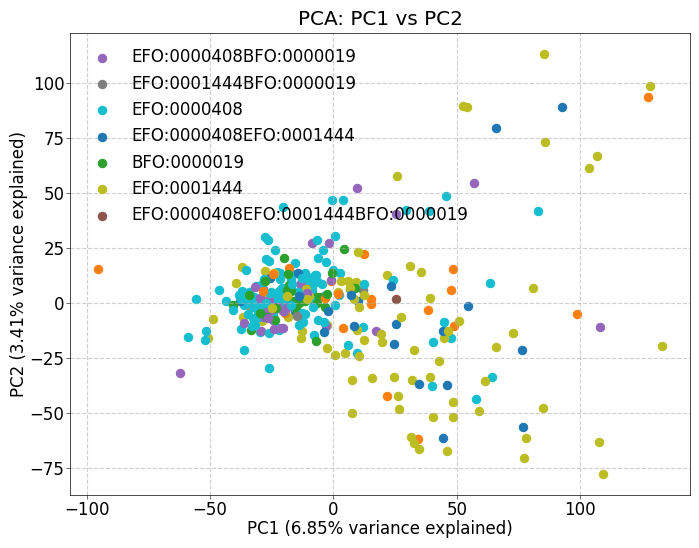

In [667]:
plot_pca(pca, var, pc_x=1, pc_y=2, classifications=trait_match_df.set_index('trait_pair').Class.to_dict())